# Humidity Prediction Study Analysis

This notebook analyzes experimental data from the trust and uncertainty visualization study.
The study examines how different visualization conditions affect user trust, confidence, and decision-making across two phases.

In [49]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
import json
import warnings
import math
warnings.filterwarnings('ignore')

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
import matplotlib.patches as mpatches

# Set plotting style
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

## 1. Data Loading and Preprocessing

In [50]:
# Load all CSV files from the data directory
data_dir = Path('./data')
csv_files = list(data_dir.glob('user_*.csv'))
print(f"Found {len(csv_files)} participant data files:")
for file in csv_files:
	print(f"  - {file.name}")

Found 173 participant data files:
  - user_6089735777946_2025-12-09T17-01-45-780.csv
  - user_695272818458144_2026-01-31T17-45-54-303.csv
  - user_67883955903455336_2025-12-09T17-53-48-921.csv
  - user_628006356316271_2026-01-31T18-09-05-297.csv
  - user_69728488059013259_2026-01-31T17-54-31-374.csv
  - user_592066604800015314_2025-12-09T17-22-45-966.csv
  - user_616406521417496381_2026-01-31T17-34-32-774.csv
  - user_62887115650_2026-01-31T18-13-59-885.csv
  - user_6583170415618439_2026-01-31T19-00-47-274.csv
  - user_6107479272809791083_2025-12-09T16-51-58-536.csv
  - user_66780980817940_2026-01-31T18-01-54-452.csv
  - user_6765111943005_2025-12-09T18-27-16-023.csv
  - user_6950677509267716_2026-01-31T17-43-17-625.csv
  - user_6551473178893958516_2026-01-31T17-49-00-826.csv
  - user_6965772556141164954_2026-01-31T17-44-21-743.csv
  - user_682451279292_2026-01-31T17-46-14-434.csv
  - user_607905333981609_2026-01-31T18-46-36-586.csv
  - user_667670523018606_2025-12-09T16-58-30-857.csv


In [51]:
# Function to load and clean individual participant data
def load_participant_data(file_path):
	"""Load a single participant CSV file and clean the data"""
	try:
		df = pd.read_csv(file_path)
		
		# Extract participant ID from filename if not in data
		if 'participant_id' not in df.columns or df['participant_id'].isna().all():
			participant_id = file_path.stem.split('_')[1]  # Extract from filename
			df['participant_id'] = participant_id
		
		# Clean condition IDs and names
		if 'condition_id' in df.columns:
			df['condition_id'] = df['condition_id'].fillna('unknown')
		
		return df
	except Exception as e:
		print(f"Error loading {file_path}: {e}")
		return None

# Load all participant data
all_data = []
for file_path in csv_files:
	participant_data = load_participant_data(file_path)
	if participant_data is not None:
		all_data.append(participant_data)
		print(f"Loaded data for participant: {participant_data['participant_id'].iloc[0] if not participant_data['participant_id'].isna().all() else 'unknown'}")

# Combine all participant data
if all_data:
	combined_data = pd.concat(all_data, ignore_index=True)
	print(f"\nCombined dataset shape (before filtering): {combined_data.shape}")
	
	# Filter out test participants
	test_participants = ['test', 'Test', 'TEST']
	before_count = combined_data['participant_id'].nunique()
	combined_data = combined_data[~combined_data['participant_id'].isin(test_participants)]
	combined_data = combined_data[combined_data['participant_id'].notna()]  # Also remove NaN participants
	after_count = combined_data['participant_id'].nunique()
	
	print(f"Filtered out test participants and NaN entries")
	print(f"Participants: {before_count} → {after_count}")
	print(f"Final dataset shape: {combined_data.shape}")
else:
	print("No data loaded successfully")

Loaded data for participant: 60ce89c7357eeffe77fca946
Loaded data for participant: 6952d7f281ec84eb5814e4db
Loaded data for participant: 6788d3955e9c0345fd53cc36
Loaded data for participant: 628e0063fa56e316da2a71cb
Loaded data for participant: 697e28c48ef80590132e5c9c
Loaded data for participant: 5bc9206a66d04800015cf314
Loaded data for participant: 61640652141bd74963f8f1cb
Loaded data for participant: 628deac8711dee5dbda650ae
Loaded data for participant: 65831ec7a0cb41561b8e43e9
Loaded data for participant: 61074792728f0f9e791ad083
Loaded data for participant: 66e7a809808daaac1a79dd40
Loaded data for participant: 67df65cf111af9caf43e00a5
Loaded data for participant: 695ffb067d7ad5092a6d7716
Loaded data for participant: 65d514731a78f893b95a8516
Loaded data for participant: 6965ba772b55e614116e4954
Loaded data for participant: 6824fd5f12b792fdaec9b2be
Loaded data for participant: 607905c3accba3e398fc1609
Loaded data for participant: 66d76d7e0523ccc0cd1a8606
Loaded data for participant:

In [52]:
# Function to identify participants with inconsistent responses
def identify_inconsistent_participants(df):
	"""
	Identify participants with inconsistent responses:
	- Choose City B but estimate P(City A > City B) < 50%
	- Choose City A but estimate P(City A > City B) > 50%
	
	Returns: DataFrame with inconsistent participants and their details
	"""
	inconsistent_participants = []
	
	# Get prediction task data only
	pred_data = df[df['trial_type'] == 'prediction-task'].copy()
	
	for participant_id in pred_data['participant_id'].unique():
		participant_rows = pred_data[pred_data['participant_id'] == participant_id]
		
		for _, row in participant_rows.iterrows():
			prob_est = row.get('probability_estimate')
			travel_choice = row.get('travel_choice')
			phase = row.get('phase', 'unknown')
			condition = row.get('condition_name', 'unknown')
			
			if pd.notna(prob_est) and pd.notna(travel_choice) and travel_choice in ['City A', 'City B']:
				# Check for inconsistency
				is_inconsistent = False
				inconsistency_type = None
				
				if travel_choice == 'City B' and prob_est < 50:
					# Participant chooses City B but thinks City A has lower probability
					is_inconsistent = True
					inconsistency_type = 'chose_city_b_but_low_prob_cityA'
				elif travel_choice == 'City A' and prob_est > 50:
					# Participant chooses City A but thinks City A has higher probability  
					is_inconsistent = True
					inconsistency_type = 'chose_city_a_but_high_prob_cityA'
				
				if is_inconsistent:
					inconsistent_participants.append({
						'participant_id': participant_id,
						'phase': phase,
						'condition': condition,
						'travel_choice': travel_choice,
						'probability_estimate': prob_est,
						'inconsistency_type': inconsistency_type
					})
	
	return pd.DataFrame(inconsistent_participants)

def filter_consistent_participants(df, verbose=True):
	"""
	Filter out participants with inconsistent responses
	
	Args:
		df: Original dataframe
		verbose: Print filtering details
		
	Returns:
		Filtered dataframe with consistent participants only
	"""
	# Identify inconsistent participants
	inconsistent_df = identify_inconsistent_participants(df)
	
	if len(inconsistent_df) > 0:
		inconsistent_participant_ids = inconsistent_df['participant_id'].unique()
		
		if verbose:
			print(f"Found {len(inconsistent_participant_ids)} participants with inconsistent responses:")
			for participant_id in inconsistent_participant_ids:
				participant_issues = inconsistent_df[inconsistent_df['participant_id'] == participant_id]
				print(f"  {participant_id}:")
				for _, issue in participant_issues.iterrows():
					print(f"    Phase {issue['phase']}: chose {issue['travel_choice']} but estimated P(City A > City B) = {issue['probability_estimate']}%")
		
		# Filter out inconsistent participants
		filtered_df = df[~df['participant_id'].isin(inconsistent_participant_ids)].copy()
		
		if verbose:
			original_participants = df['participant_id'].nunique()
			filtered_participants = filtered_df['participant_id'].nunique()
			print(f"\nFiltering results:")
			print(f"  Original participants: {original_participants}")
			print(f"  Inconsistent participants removed: {len(inconsistent_participant_ids)}")
			print(f"  Remaining participants: {filtered_participants}")
		
		return filtered_df, inconsistent_df
	else:
		if verbose:
			print("No inconsistent participants found.")
		return df, pd.DataFrame()

print("Consistency checking functions defined.")

Consistency checking functions defined.


In [53]:
# Examine the data structure
print("Column names:")
print(combined_data.columns.tolist())
print(f"\nDataset shape: {combined_data.shape}")
# print(f"\nUnique trial types:")
# print(combined_data['trial_type'].value_counts())

Column names:
['city_a_estimate', 'city_b_estimate', 'click_events', 'comprehension_ease', 'condition', 'condition_id', 'condition_name', 'confidence_label', 'confidence_rating', 'data_trust', 'display_format', 'end_time', 'failed_audio', 'failed_images', 'failed_video', 'hover_events', 'interaction_log', 'internal_node_id', 'participant_id', 'percent_score', 'phase', 'phase1_complete', 'phase2_complete', 'predictions_shown', 'probability_estimate', 'question_order', 'response', 'responses', 'round', 'rt', 'rt_total', 'skeptical_rating', 'slider_moved', 'start_time', 'stimulus', 'success', 'time_elapsed', 'time_on_viz', 'timeout', 'total_interactions', 'total_questions', 'total_score', 'travel_choice', 'trial_index', 'trial_type', 'trust_composite', 'usability_composite', 'usability_difficulty', 'view_history', 'visualization_literacy_score', 'visualization_shown']

Dataset shape: (3426, 51)


In [54]:
# Filter for relevant trial types (prediction tasks and surveys)
relevant_trials = combined_data[
	combined_data['trial_type'].isin([
		'prediction-task', 'vis-literacy', 'trust-survey', 
		'personality-survey', 'survey-text', 'survey-multi-choice'
	])
].copy()

print(f"Filtered dataset shape: {relevant_trials.shape}")
print(f"\nTrial types in filtered data:")
print(relevant_trials['trial_type'].value_counts())

Filtered dataset shape: (1540, 51)

Trial types in filtered data:
trial_type
survey-text            343
prediction-task        342
trust-survey           342
vis-literacy           171
personality-survey     171
survey-multi-choice    171
Name: count, dtype: int64


In [55]:
# Create interaction_freq column from interaction_log string length
relevant_trials['interaction_freq'] = np.log(relevant_trials['interaction_log'].astype(str).str.len())

print(f"Added interaction_freq column to relevant_trials dataset")
print(f"Dataset shape: {relevant_trials.shape}")
print(f"\nInteraction frequency statistics:")
print(relevant_trials['interaction_freq'].describe())

# Show a few sample values to verify the new column
print(f"\nSample interaction_log vs interaction_freq values:")
sample = relevant_trials[['interaction_log', 'interaction_freq']].head(5)
for idx, row in sample.iterrows():
	log_val = str(row['interaction_log'])[:50] + "..." if len(str(row['interaction_log'])) > 50 else str(row['interaction_log'])
	print(f"Log: {log_val} | Freq: {row['interaction_freq']}")

Added interaction_freq column to relevant_trials dataset
Dataset shape: (1540, 52)

Interaction frequency statistics:
count    1540.000000
mean        2.744310
std         3.490936
min         0.693147
25%         1.098612
50%         1.098612
75%         1.098612
max        12.983267
Name: interaction_freq, dtype: float64

Sample interaction_log vs interaction_freq values:
Log: nan | Freq: 1.0986122886681098
Log: nan | Freq: 1.0986122886681098
Log: [{"type":"chart_enter","data":{"timestamp":26822.5... | Freq: 10.470078954207976
Log: [{"type":"chart_enter","data":{"timestamp":10922.0... | Freq: 10.337669684741787
Log: nan | Freq: 1.0986122886681098


In [56]:
# # Apply consistency filtering to the dataset
# print("=" * 60)
# print("CHECKING FOR INCONSISTENT PARTICIPANTS")
# print("=" * 60)

# # Apply the filter to your combined_data
# combined_data, inconsistent_participants = filter_consistent_participants(combined_data, verbose=True)

# # Update the relevant_trials dataset as well
# if len(inconsistent_participants) > 0:
#     inconsistent_ids = inconsistent_participants['participant_id'].unique()
#     relevant_trials_filtered = relevant_trials[~relevant_trials['participant_id'].isin(inconsistent_ids)].copy()
#     print(f"\nRelevant trials dataset:")
#     print(f"  Original shape: {relevant_trials.shape}")
#     print(f"  Filtered shape: {relevant_trials_filtered.shape}")
# else:
#     relevant_trials_filtered = relevant_trials.copy()
	
# relevant_trials=relevant_trials_filtered
# print("\n" + "=" * 60)

In [57]:
# Examine condition distribution
print("Unique conditions:")
condition_counts = relevant_trials['condition_id'].value_counts(dropna=False)
print(condition_counts)

print("\nCondition names:")
condition_names = relevant_trials[['condition_id', 'condition_name']].drop_duplicates().dropna()
for _, row in condition_names.iterrows():
	print(f"  {row['condition_id']}: {row['condition_name']}")

Unique conditions:
condition_id
unknown                       171
condition_0_historical        171
condition_5_pi_hover          147
condition_9_combined          140
condition_7_buggy             140
condition_6_pi_to_ensemble    133
condition_4_ensemble_hover    133
condition_2_pi_plot           126
condition_1_baseline          126
condition_8_bad               126
condition_3_ensemble          126
NaN                             1
Name: count, dtype: int64

Condition names:
  condition_6_pi_to_ensemble: PI → Ensemble
  condition_0_historical: Historical Only
  condition_2_pi_plot: PI Plot
  condition_1_baseline: Baseline
  condition_9_combined: Combined PI + Ensemble
  condition_8_bad: Bad Control
  condition_4_ensemble_hover: Ensemble + Hover
  condition_7_buggy: Buggy Control
  condition_5_pi_hover: PI Plot + Hover
  condition_3_ensemble: Ensemble Plot


In [58]:
# Separate Phase 1 and Phase 2 data
prediction_data = relevant_trials[relevant_trials['trial_type'] == 'prediction-task'].copy()

# Phase separation logic
phase1_data = prediction_data[prediction_data['phase'] == 1].copy()
phase2_data = prediction_data[prediction_data['phase'] == 2].copy()

print(f"Phase 1 data: {len(phase1_data)} rows")
print(f"Phase 2 data: {len(phase2_data)} rows")

# Get visualization literacy data
vis_literacy_data = relevant_trials[relevant_trials['trial_type'] == 'vis-literacy'].copy()
print(f"Visualization literacy data: {len(vis_literacy_data)} rows")

# Separate different types of survey data

# Get trust-survey data (interface interaction and visualization trust questions)
all_trust_surveys = relevant_trials[relevant_trials['trial_type'] == 'trust-survey'].copy()
print(f"All trust survey data: {len(all_trust_surveys)} rows")

# Get personality survey data (demographics questions)
all_personality_surveys = relevant_trials[relevant_trials['trial_type'] == 'personality-survey'].copy()
print(f"All personality survey data: {len(all_personality_surveys)} rows")

# Function to check if a row represents a specific survey type based on question_order
def get_survey_type(row):
	"""Determine survey type based on question_order content"""
	if 'question_order' in row and pd.notna(row['question_order']):
		try:
			question_order = eval(row['question_order'])  # Convert string to list
			if isinstance(question_order, list) and len(question_order) > 0:
				first_question = question_order[0]
				
				# Define the first question of each survey type
				if first_question == 'navigation_control':
					return 'interaction'
				elif first_question == 'skeptical_rating':
					return 'trust'
				elif first_question == 'respect_others':
					return 'demographics'
		except:
			pass
	return 'unknown'

# Add survey type classification to trust surveys
all_trust_surveys['survey_type'] = all_trust_surveys.apply(get_survey_type, axis=1)

# Separate the data based on survey types
interaction_data = all_trust_surveys[all_trust_surveys['survey_type'] == 'interaction'].copy()
trust_data = all_trust_surveys[all_trust_surveys['survey_type'] == 'trust'].copy()
demographics_data = all_personality_surveys.copy()  # Demographics is in personality-survey trial type

print(f"Interaction data: {len(interaction_data)} rows")
print(f"Trust data: {len(trust_data)} rows") 
print(f"Demographics data: {len(demographics_data)} rows")

# Show survey type distribution
print(f"\nTrust survey type distribution:")
print(all_trust_surveys['survey_type'].value_counts())

Phase 1 data: 171 rows
Phase 2 data: 171 rows
Visualization literacy data: 171 rows
All trust survey data: 342 rows
All personality survey data: 171 rows
Interaction data: 171 rows
Trust data: 171 rows
Demographics data: 171 rows

Trust survey type distribution:
survey_type
interaction    171
trust          171
Name: count, dtype: int64


## 2. Basic Statistics Tables by Condition

Each table shows conditions as rows and response variables as columns, with participant response lists in each cell.

In [59]:
def create_condition_response_table(data, response_columns, title="Response Table"):
	"""
	Create a table where each row is a condition and each column is a response variable.
	Each cell contains a list of participant responses.
	"""
	# Get unique conditions
	conditions = sorted(data['condition_id'].dropna().unique())
	
	# Initialize results dictionary
	results = {}
	
	for condition in conditions:
		condition_data = data[data['condition_id'] == condition]
		condition_responses = {}
		
		for col in response_columns:
			if col in condition_data.columns:
				responses = condition_data[col].dropna().tolist()
				condition_responses[col] = responses
			else:
				condition_responses[col] = []
		
		results[condition] = condition_responses
	
	# Convert to DataFrame
	df = pd.DataFrame(results).T
	
	print(f"\n{title}")
	print("=" * len(title))
	return df

# Function to display response summary statistics
def display_response_summary(df, title="Summary"):
	"""
	Display summary statistics for response lists in each cell
	"""
	print(f"\n{title} - Response Counts and Basic Stats")
	print("-" * (len(title) + 30))
	
	for condition in df.index:
		print(f"\nCondition: {condition}")
		for col in df.columns:
			responses = df.loc[condition, col]
			if isinstance(responses, list) and responses:
				numeric_responses = [r for r in responses if isinstance(r, (int, float)) and not pd.isna(r)]
				if numeric_responses:
					print(f"  {col}: n={len(numeric_responses)}, mean={np.mean(numeric_responses):.2f}, responses={numeric_responses}")
				else:
					print(f"  {col}: n={len(responses)}, responses={responses[:5]}{'...' if len(responses) > 5 else ''}")
			else:
				print(f"  {col}: No responses")
	
	return df

### Phase 1 Responses (Baseline - No Visualization)

In [60]:
# Phase 1 response columns
phase1_columns = ['probability_estimate', 'confidence_rating', 'travel_choice']

# Create Phase 1 table
phase1_table = create_condition_response_table(
	phase1_data, 
	phase1_columns, 
	"Phase 1 Responses (No Visualization)"
)

# Display the table
# display_response_summary(phase1_table, "Phase 1 Summary")


Phase 1 Responses (No Visualization)


### Phase 2 Responses (With Visualization)

In [61]:
# Phase 2 response columns
phase2_columns = ['probability_estimate', 'confidence_rating', 'travel_choice', 'data_trust', 'skeptical_rating']

# Create Phase 2 table
phase2_table = create_condition_response_table(
	phase2_data, 
	phase2_columns, 
	"Phase 2 Responses (With Visualization)"
)

# Display the table
# display_response_summary(phase2_table, "Phase 2 Summary")


Phase 2 Responses (With Visualization)


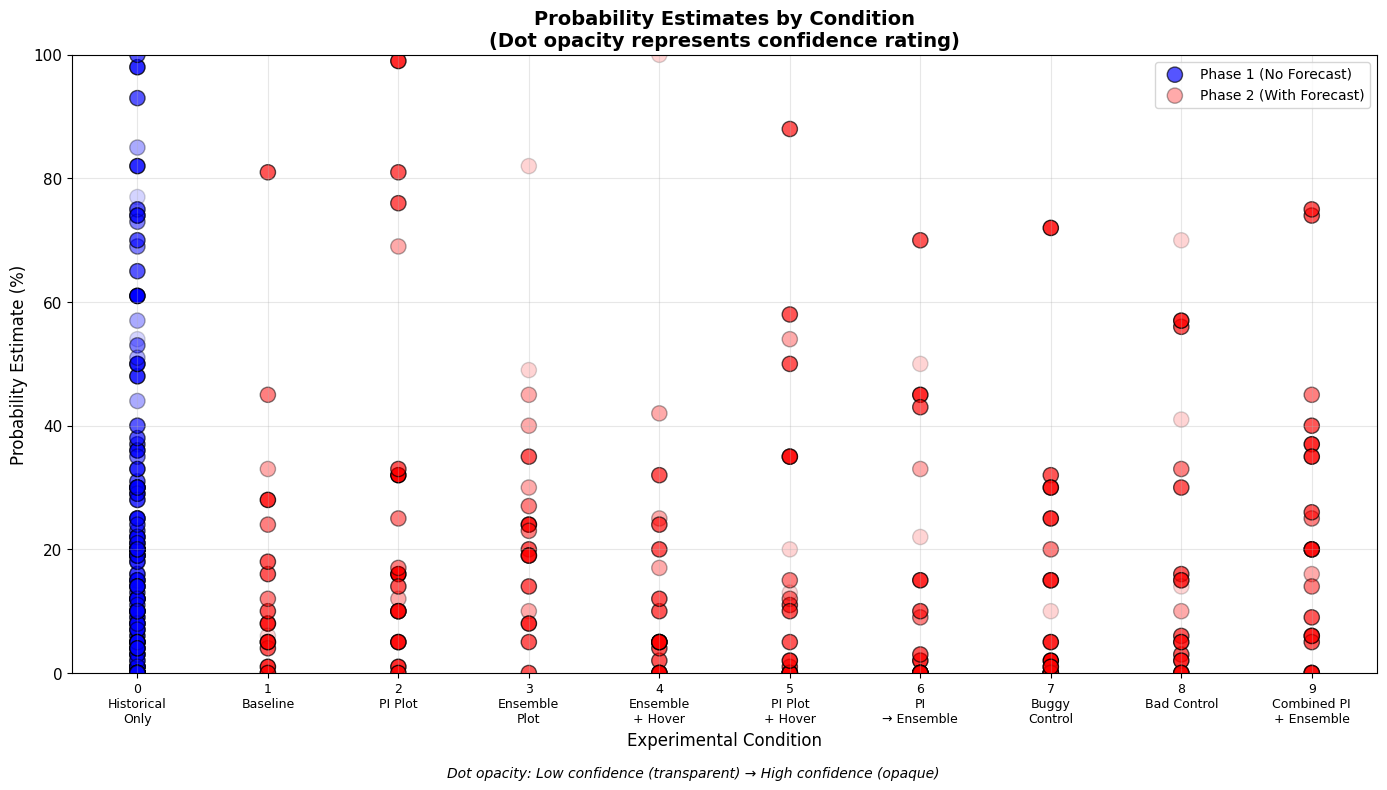


Visualization Data Summary:
Phase 1: 171 data points
Phase 2: 171 data points
Conditions with data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Condition Mapping:
  ✓ Condition 0: Historical Only
  ✓ Condition 1: Baseline
  ✓ Condition 2: PI Plot
  ✓ Condition 3: Ensemble Plot
  ✓ Condition 4: Ensemble + Hover
  ✓ Condition 5: PI Plot + Hover
  ✓ Condition 6: PI → Ensemble
  ✓ Condition 7: Buggy Control
  ✓ Condition 8: Bad Control
  ✓ Condition 9: Combined PI + Ensemble


In [62]:
# Create combined dot plot visualization with probability estimates by condition
# Opacity based on confidence rating

def create_probability_dot_plot():
	"""Create a dot plot showing probability estimates by condition with confidence-based opacity"""
	
	# Define condition mapping
	condition_names = {
		0: "Historical Only",
		1: "Baseline", 
		2: "PI Plot",
		3: "Ensemble Plot",
		4: "Ensemble + Hover", 
		5: "PI Plot + Hover",
		6: "PI → Ensemble",
		7: "Buggy Control",
		8: "Bad Control",
		9: "Combined PI + Ensemble"
	}
	
	# Combine Phase 1 and Phase 2 data for visualization
	viz_data = []
	
	# Add Phase 1 data
	for _, row in phase1_data.iterrows():
		if pd.notna(row['probability_estimate']) and pd.notna(row['confidence_rating']):
			viz_data.append({
				'condition_id': row['condition_id'],
				'probability_estimate': row['probability_estimate'],
				'confidence_rating': row['confidence_rating'],
				'phase': 'Phase 1'
			})
	
	# Add Phase 2 data
	for _, row in phase2_data.iterrows():
		if pd.notna(row['probability_estimate']) and pd.notna(row['confidence_rating']):
			viz_data.append({
				'condition_id': row['condition_id'],
				'probability_estimate': row['probability_estimate'],
				'confidence_rating': row['confidence_rating'],
				'phase': 'Phase 2'
			})
	
	if not viz_data:
		print("No data available for visualization")
		return
	
	viz_df = pd.DataFrame(viz_data)
	
	# Extract condition numbers for x-axis ordering
	def extract_condition_number(condition_id):
		if pd.isna(condition_id) or condition_id == 'unknown':
			return -1
		try:
			# Extract number from condition_X_name format
			parts = str(condition_id).split('_')
			if len(parts) >= 2:
				return int(parts[1])
		except:
			pass
		return -1
	
	viz_df['condition_number'] = viz_df['condition_id'].apply(extract_condition_number)
	viz_df = viz_df[viz_df['condition_number'] >= 0]  # Remove unknown conditions
	
	# Normalize confidence rating to 0-1 for opacity (1-7 scale -> 0-1 scale)
	viz_df['opacity'] = (viz_df['confidence_rating'] - 1) / 6  # Convert 1-7 to 0-1
	
	# Create the combined plot
	fig, ax = plt.subplots(1, 1, figsize=(14, 8))
	
	# Plot Phase 1 and Phase 2 data with different colors
	phase1_viz = viz_df[viz_df['phase'] == 'Phase 1']
	phase2_viz = viz_df[viz_df['phase'] == 'Phase 2']
	
	if len(phase1_viz) > 0:
		ax.scatter(phase1_viz['condition_number'], 
				  phase1_viz['probability_estimate'],
				  alpha=phase1_viz['opacity'],
				  s=120, c='blue', edgecolors='black', linewidth=1,
				  label='Phase 1 (No Forecast)')
	
	if len(phase2_viz) > 0:
		ax.scatter(phase2_viz['condition_number'], 
				  phase2_viz['probability_estimate'],
				  alpha=phase2_viz['opacity'],
				  s=120, c='red', edgecolors='black', linewidth=1,
				  label='Phase 2 (With Forecast)')
	
	# Set up the plot
	ax.set_title('Probability Estimates by Condition\n(Dot opacity represents confidence rating)', 
				fontsize=14, fontweight='bold')
	ax.set_xlabel('Experimental Condition', fontsize=12)
	ax.set_ylabel('Probability Estimate (%)', fontsize=12)
	ax.set_ylim(0, 100)
	ax.grid(True, alpha=0.3)
	
	# Force x-axis to show all conditions 0-9
	ax.set_xlim(-0.5, 9.5)
	ax.set_xticks(range(10))
	
	# Create condition labels for x-axis
	condition_labels = []
	for i in range(10):
		if i in condition_names:
			# Wrap long names for better display
			name = condition_names[i]
			if len(name) > 12:
				words = name.split()
				if len(words) > 1:
					mid = len(words) // 2
					name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
			condition_labels.append(f"{i}\n{name}")
		else:
			condition_labels.append(f"{i}\n(No Data)")
	
	ax.set_xticklabels(condition_labels, fontsize=9, ha='center')
	
	# Add legend
	ax.legend(loc='upper right', fontsize=10)
	
	# Add opacity explanation
	fig.text(0.5, 0.02, 'Dot opacity: Low confidence (transparent) → High confidence (opaque)', 
			 ha='center', fontsize=10, style='italic')
	
	plt.tight_layout()
	plt.subplots_adjust(bottom=0.15)
	plt.show()
	
	# Print summary statistics
	print(f"\nVisualization Data Summary:")
	print(f"Phase 1: {len(phase1_viz)} data points")
	print(f"Phase 2: {len(phase2_viz)} data points")
	print(f"Conditions with data: {sorted(viz_df['condition_number'].unique())}")
	
	# Show condition mapping
	print(f"\nCondition Mapping:")
	present_conditions = sorted(viz_df['condition_number'].unique())
	for i in range(10):
		status = "✓" if i in present_conditions else "✗"
		name = condition_names.get(i, "Unknown")
		print(f"  {status} Condition {i}: {name}")
	
	return viz_df

# Create the visualization
viz_summary = create_probability_dot_plot()


Humidity Estimate Shift Summary:
Participants with matched baseline: 171
Interaction frequency range: 0.6931471805599453 - 12.983266813615733

Mean shift by condition (from Condition 0 baseline):
----------------------------------------------------------------------
  Condition 1 (Baseline): n=18
      City A: ↑ +6.28 (SD=7.98)
      City B: ↑ +7.39 (SD=7.21)
  Condition 2 (PI Plot): n=18
      City A: ↑ +6.03 (SD=6.03)
      City B: ↑ +7.87 (SD=4.39)
  Condition 3 (Ensemble Plot): n=18
      City A: ↑ +9.25 (SD=7.87)
      City B: ↑ +9.58 (SD=7.73)
  Condition 4 (Ensemble + Hover): n=19
      City A: ↑ +7.84 (SD=7.88)
      City B: ↑ +8.13 (SD=5.90)
  Condition 5 (PI Plot + Hover): n=21
      City A: ↑ +8.10 (SD=8.93)
      City B: ↑ +4.62 (SD=5.42)
  Condition 6 (PI → Ensemble): n=19
      City A: ↑ +5.32 (SD=16.39)
      City B: ↑ +2.11 (SD=16.74)
  Condition 7 (Buggy Control): n=20
      City A: ↑ +6.80 (SD=4.01)
      City B: ↑ +9.45 (SD=7.80)
  Condition 8 (Bad Control): n=18
  

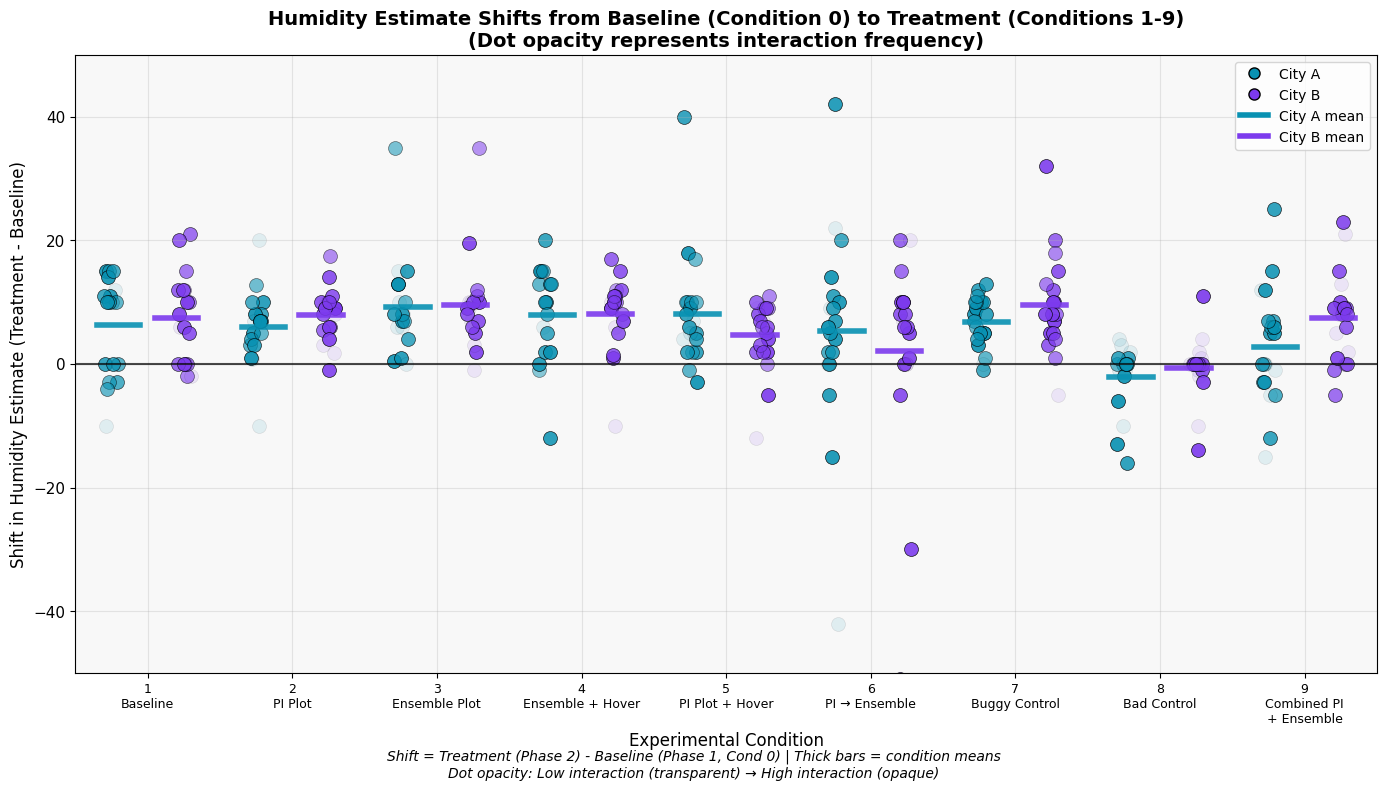

In [63]:
# Modified function to use interaction_freq for opacity instead of confidence
def create_probability_shift_plot_v2(phase1_data, phase2_data):
	"""
	Create a dot plot showing the shift in probability estimates from Phase 1 (baseline) to Phase 2.
	
	Parameters:
	- phase1_data: DataFrame with Phase 1 data (condition 0 baseline)
				   Columns: participant_id, city_a_estimate, city_b_estimate, confidence_rating
	- phase2_data: DataFrame with Phase 2 data (conditions 1-9)
				   Columns: participant_id, condition_id, city_a_estimate, city_b_estimate, confidence_rating, interaction_freq
	
	City A and City B shifts are shown separately with different colors.
	Dot opacity represents interaction frequency.
	"""
	
	# Define colors
	CITY_A_COLOR = '#0891B2'  # Teal for City A
	CITY_B_COLOR = '#7C3AED'  # Purple for City B
	
	# Define condition mapping
	condition_names = {
		1: "Baseline", 
		2: "PI Plot",
		3: "Ensemble Plot",
		4: "Ensemble + Hover", 
		5: "PI Plot + Hover",
		6: "PI → Ensemble",
		7: "Buggy Control",
		8: "Bad Control",
		9: "Combined PI\n+ Ensemble"
	}
	
	# Helper function to extract condition number
	def extract_condition_number(condition_id):
		if pd.isna(condition_id) or condition_id == 'unknown':
			return -1
		try:
			parts = str(condition_id).split('_')
			if len(parts) >= 2:
				return int(parts[1])
		except:
			pass
		return -1
	
	# Process Phase 1 data (baseline - condition 0)
	phase1_dict = {}  # participant_id -> {city_a, city_b, confidence}
	for _, row in phase1_data.iterrows():
		if pd.notna(row['city_a_estimate']) and pd.notna(row['city_b_estimate']):
			pid = row.get('participant_id', row.name)
			phase1_dict[pid] = {
				'city_a_estimate': row['city_a_estimate'],
				'city_b_estimate': row['city_b_estimate'],
				'confidence_rating': row.get('confidence_rating', 4)
			}
	
	# Process Phase 2 data and calculate shifts
	shift_data = []
	for _, row in phase2_data.iterrows():
		if pd.notna(row['city_a_estimate']) and pd.notna(row['city_b_estimate']):
			pid = row.get('participant_id', row.name)
			cond_num = extract_condition_number(row['condition_id'])
			
			# Only include conditions 1-9 and participants with baseline data
			if cond_num >= 1 and cond_num <= 9 and pid in phase1_dict:
				baseline = phase1_dict[pid]
				
				# Calculate shift for each city
				shift_a = row['city_a_estimate'] - baseline['city_a_estimate']
				shift_b = row['city_b_estimate'] - baseline['city_b_estimate']
				
				# Get interaction frequency (default to 0 if missing)
				interaction_freq = row.get('interaction_freq', 0)
				
				shift_data.append({
					'participant_id': pid,
					'condition_number': cond_num,
					'shift_a': shift_a,
					'shift_b': shift_b,
					'interaction_freq': interaction_freq
				})
	
	if len(shift_data) == 0:
		print("No matched data found for shift calculation")
		print(f"Phase 1 participants: {len(phase1_dict)}")
		print(f"Phase 2 rows: {len(phase2_data)}")
		return None
	
	shift_df = pd.DataFrame(shift_data)
	
	# Normalize interaction_freq to 0.1-1.0 for opacity (for visibility)
	min_freq = shift_df['interaction_freq'].min()
	max_freq = shift_df['interaction_freq'].max()
	if max_freq > min_freq:
		shift_df['opacity'] = 0.1 + (shift_df['interaction_freq'] - min_freq) / (max_freq - min_freq) * 0.9
	else:
		shift_df['opacity'] = 0.7  # Default opacity if all frequencies are the same
	
	# Create the plot
	fig, ax = plt.subplots(1, 1, figsize=(14, 8))
	
	# Add horizontal line at y=0
	ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
	
	# Add shaded regions
	ax.axhspan(0, 50, alpha=0.05, color='gray')
	ax.axhspan(-50, 0, alpha=0.05, color='gray')
	
	# Add jitter to x-axis to avoid overlapping points
	np.random.seed(42)  # For reproducibility
	jitter_a = np.random.uniform(-0.15, -0.05, len(shift_df))  # City A slightly to the left
	jitter_b = np.random.uniform(0.05, 0.15, len(shift_df))    # City B slightly to the right
	x_positions_a = shift_df['condition_number'] - 0.15 + jitter_a
	x_positions_b = shift_df['condition_number'] + 0.15 + jitter_b
	
	# Plot City A shifts (teal) with interaction frequency-based opacity
	for x, y, opacity in zip(x_positions_a, shift_df['shift_a'], shift_df['opacity']):
		ax.scatter(x, y, alpha=opacity, s=100, c=CITY_A_COLOR, edgecolors='black', linewidth=0.5)
	
	# Plot City B shifts (purple) with interaction frequency-based opacity
	for x, y, opacity in zip(x_positions_b, shift_df['shift_b'], shift_df['opacity']):
		ax.scatter(x, y, alpha=opacity, s=100, c=CITY_B_COLOR, edgecolors='black', linewidth=0.5)
	
	# Calculate and plot mean shift per condition for each city
	mean_shifts_a = shift_df.groupby('condition_number')['shift_a'].mean()
	mean_shifts_b = shift_df.groupby('condition_number')['shift_b'].mean()
	
	for cond in range(1, 10):
		if cond in mean_shifts_a.index:
			# City A mean (teal bar, left side)
			ax.plot([cond - 0.35, cond - 0.05], [mean_shifts_a[cond], mean_shifts_a[cond]], 
				   color=CITY_A_COLOR, linewidth=4, alpha=0.9)
		if cond in mean_shifts_b.index:
			# City B mean (purple bar, right side)
			ax.plot([cond + 0.05, cond + 0.35], [mean_shifts_b[cond], mean_shifts_b[cond]], 
				   color=CITY_B_COLOR, linewidth=4, alpha=0.9)
	
	# Set up the plot
	ax.set_title('Humidity Estimate Shifts from Baseline (Condition 0) to Treatment (Conditions 1-9)\n(Dot opacity represents interaction frequency)', 
				fontsize=14, fontweight='bold')
	ax.set_xlabel('Experimental Condition', fontsize=12)
	ax.set_ylabel('Shift in Humidity Estimate (Treatment - Baseline)', fontsize=12)
	ax.set_ylim(-50, 50)
	ax.set_xlim(0.5, 9.5)
	ax.set_xticks(range(1, 10))
	ax.grid(True, alpha=0.3, axis='y')
	
	# Create condition labels for x-axis
	condition_labels = []
	for i in range(1, 10):
		name = condition_names.get(i, f"Cond {i}")
		condition_labels.append(f"{i}\n{name}")
	
	ax.set_xticklabels(condition_labels, fontsize=9, ha='center')
	
	# Add custom legend
	from matplotlib.patches import Patch
	from matplotlib.lines import Line2D
	legend_elements = [
		Line2D([0], [0], marker='o', color='w', markerfacecolor=CITY_A_COLOR, 
			   markersize=8, label='City A', markeredgecolor='black'),
		Line2D([0], [0], marker='o', color='w', markerfacecolor=CITY_B_COLOR, 
			   markersize=8, label='City B', markeredgecolor='black'),
		Line2D([0], [0], color=CITY_A_COLOR, linewidth=4, label='City A mean'),
		Line2D([0], [0], color=CITY_B_COLOR, linewidth=4, label='City B mean')
	]
	ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
	
	# Add explanation
	fig.text(0.5, 0.02, 'Shift = Treatment (Phase 2) - Baseline (Phase 1, Cond 0) | Thick bars = condition means\nDot opacity: Low interaction (transparent) → High interaction (opaque)', 
			 ha='center', fontsize=10, style='italic')
	
	plt.tight_layout()
	plt.subplots_adjust(bottom=0.15)
	
	# Print summary statistics
	print(f"\nHumidity Estimate Shift Summary:")
	print(f"Participants with matched baseline: {len(shift_df)}")
	print(f"Interaction frequency range: {min_freq} - {max_freq}")
	print(f"\nMean shift by condition (from Condition 0 baseline):")
	print("-" * 70)
	for cond in range(1, 10):
		cond_data = shift_df[shift_df['condition_number'] == cond]
		if len(cond_data) > 0:
			mean_a = cond_data['shift_a'].mean()
			std_a = cond_data['shift_a'].std()
			mean_b = cond_data['shift_b'].mean()
			std_b = cond_data['shift_b'].std()
			n = len(cond_data)
			
			dir_a = "↑" if mean_a > 0 else "↓" if mean_a < 0 else "→"
			dir_b = "↑" if mean_b > 0 else "↓" if mean_b < 0 else "→"
			cond_name = condition_names.get(cond, 'Unknown')
			
			print(f"  Condition {cond} ({cond_name}): n={n}")
			print(f"      City A: {dir_a} {mean_a:+.2f} (SD={std_a:.2f})")
			print(f"      City B: {dir_b} {mean_b:+.2f} (SD={std_b:.2f})")
		else:
			print(f"  Condition {cond}: No data")
	
	plt.show()
	
	return shift_df

# Test the new function
shift_summary_cities_v2 = create_probability_shift_plot_v2(phase1_data, phase2_data)


Probability Estimate Shift Summary:
Participants with matched baseline: 171
Interaction frequency range: 0.6931471805599453 - 12.983266813615733

Mean shift by condition (from Condition 0 baseline):
------------------------------------------------------------
  Condition 1 (Baseline): ↓ -3.39 (SD=20.57, n=18)
  Condition 2 (PI Plot): ↑ +8.06 (SD=41.79, n=18)
  Condition 3 (Ensemble Plot): ↑ +7.33 (SD=21.22, n=18)
  Condition 4 (Ensemble + Hover): ↓ -9.84 (SD=27.67, n=19)
  Condition 5 (PI Plot + Hover): ↑ +2.14 (SD=23.85, n=21)
  Condition 6 (PI → Ensemble): ↓ -2.16 (SD=12.89, n=19)
  Condition 7 (Buggy Control): ↓ -8.40 (SD=14.57, n=20)
  Condition 8 (Bad Control): ↓ -5.00 (SD=29.87, n=18)
  Condition 9 (Combined PI
+ Ensemble): ↓ -0.50 (SD=15.25, n=20)


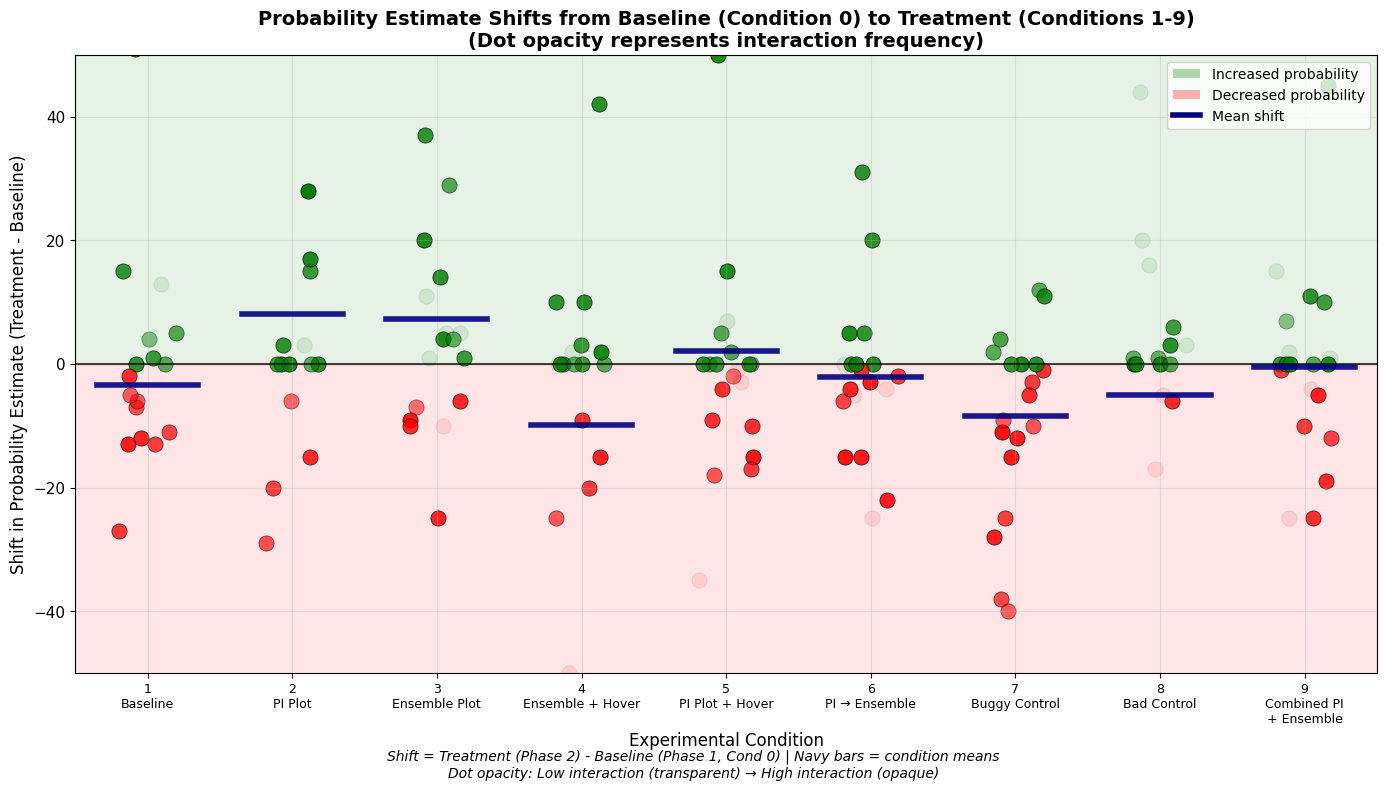

In [64]:
# Modified function to use interaction_freq for opacity instead of confidence
def create_probability_estimate_shift_plot_v2(phase1_data, phase2_data):
	"""
	Create a dot plot showing the shift in probability_estimate from Phase 1 (baseline) to Phase 2.
	
	Parameters:
	- phase1_data: DataFrame with Phase 1 data (condition 0 baseline)
				   Columns: participant_id, probability_estimate, confidence_rating
	- phase2_data: DataFrame with Phase 2 data (conditions 1-9)
				   Columns: participant_id, condition_id, probability_estimate, confidence_rating, interaction_freq
	
	Shift is calculated as Phase 2 - Phase 1 (baseline).
	Dot opacity represents interaction frequency.
	"""
	
	# Define condition mapping
	condition_names = {
		1: "Baseline", 
		2: "PI Plot",
		3: "Ensemble Plot",
		4: "Ensemble + Hover", 
		5: "PI Plot + Hover",
		6: "PI → Ensemble",
		7: "Buggy Control",
		8: "Bad Control",
		9: "Combined PI\n+ Ensemble"
	}
	
	# Helper function to extract condition number
	def extract_condition_number(condition_id):
		if pd.isna(condition_id) or condition_id == 'unknown':
			return -1
		try:
			parts = str(condition_id).split('_')
			if len(parts) >= 2:
				return int(parts[1])
		except:
			pass
		return -1
	
	# Process Phase 1 data (baseline - condition 0)
	phase1_dict = {}  # participant_id -> {probability_estimate, confidence}
	for _, row in phase1_data.iterrows():
		if pd.notna(row['probability_estimate']):
			pid = row.get('participant_id', row.name)
			phase1_dict[pid] = {
				'probability_estimate': row['probability_estimate'],
				'confidence_rating': row.get('confidence_rating', 4)
			}
	
	# Process Phase 2 data and calculate shifts
	shift_data = []
	for _, row in phase2_data.iterrows():
		if pd.notna(row['probability_estimate']):
			pid = row.get('participant_id', row.name)
			cond_num = extract_condition_number(row['condition_id'])
			
			# Only include conditions 1-9 and participants with baseline data
			if cond_num >= 1 and cond_num <= 9 and pid in phase1_dict:
				baseline = phase1_dict[pid]
				
				# Calculate shift
				shift = row['probability_estimate'] - baseline['probability_estimate']
				
				# Get interaction frequency (default to 0 if missing)
				interaction_freq = row.get('interaction_freq', 0)
				
				shift_data.append({
					'participant_id': pid,
					'condition_number': cond_num,
					'shift': shift,
					'interaction_freq': interaction_freq
				})
	
	if len(shift_data) == 0:
		print("No matched data found for shift calculation")
		print(f"Phase 1 participants: {len(phase1_dict)}")
		print(f"Phase 2 rows: {len(phase2_data)}")
		return None
	
	shift_df = pd.DataFrame(shift_data)
	
	# Normalize interaction_freq to 0.1-1.0 for opacity (for visibility)
	min_freq = shift_df['interaction_freq'].min()
	max_freq = shift_df['interaction_freq'].max()
	if max_freq > min_freq:
		shift_df['opacity'] = 0.1 + (shift_df['interaction_freq'] - min_freq) / (max_freq - min_freq) * 0.9
	else:
		shift_df['opacity'] = 0.7  # Default opacity if all frequencies are the same
	
	# Create the plot
	fig, ax = plt.subplots(1, 1, figsize=(14, 8))
	
	# Add horizontal line at y=0
	ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
	
	# Add shaded regions
	ax.axhspan(0, 50, alpha=0.1, color='green', label='Increased probability')
	ax.axhspan(-50, 0, alpha=0.1, color='red', label='Decreased probability')
	
	# Color points based on direction of shift
	colors = ['green' if s >= 0 else 'red' for s in shift_df['shift']]
	
	# Add jitter to x-axis to avoid overlapping points
	np.random.seed(42)  # For reproducibility
	jitter = np.random.uniform(-0.2, 0.2, len(shift_df))
	x_positions = shift_df['condition_number'] + jitter
	
	# Plot the shifts with interaction frequency-based opacity
	for x, y, opacity, color in zip(x_positions, shift_df['shift'], shift_df['opacity'], colors):
		ax.scatter(x, y, alpha=opacity, s=120, c=color, edgecolors='black', linewidth=0.5)
	
	# Calculate and plot mean shift per condition
	mean_shifts = shift_df.groupby('condition_number')['shift'].mean()
	for cond, mean_shift in mean_shifts.items():
		ax.plot([cond - 0.35, cond + 0.35], [mean_shift, mean_shift], 
			   color='navy', linewidth=4, alpha=0.9)
	
	# Set up the plot
	ax.set_title('Probability Estimate Shifts from Baseline (Condition 0) to Treatment (Conditions 1-9)\n(Dot opacity represents interaction frequency)', 
				fontsize=14, fontweight='bold')
	ax.set_xlabel('Experimental Condition', fontsize=12)
	ax.set_ylabel('Shift in Probability Estimate (Treatment - Baseline)', fontsize=12)
	ax.set_ylim(-50, 50)
	ax.set_xlim(0.5, 9.5)
	ax.set_xticks(range(1, 10))
	ax.grid(True, alpha=0.3, axis='y')
	
	# Create condition labels for x-axis
	condition_labels = []
	for i in range(1, 10):
		name = condition_names.get(i, f"Cond {i}")
		condition_labels.append(f"{i}\n{name}")
	
	ax.set_xticklabels(condition_labels, fontsize=9, ha='center')
	
	# Add custom legend
	from matplotlib.patches import Patch
	from matplotlib.lines import Line2D
	legend_elements = [
		Patch(facecolor='green', alpha=0.3, label='Increased probability'),
		Patch(facecolor='red', alpha=0.3, label='Decreased probability'),
		Line2D([0], [0], color='navy', linewidth=4, label='Mean shift')
	]
	ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
	
	# Add explanation
	fig.text(0.5, 0.02, 'Shift = Treatment (Phase 2) - Baseline (Phase 1, Cond 0) | Navy bars = condition means\nDot opacity: Low interaction (transparent) → High interaction (opaque)', 
			 ha='center', fontsize=10, style='italic')
	
	plt.tight_layout()
	plt.subplots_adjust(bottom=0.15)
	
	# Print summary statistics
	print(f"\nProbability Estimate Shift Summary:")
	print(f"Participants with matched baseline: {len(shift_df)}")
	print(f"Interaction frequency range: {min_freq} - {max_freq}")
	print(f"\nMean shift by condition (from Condition 0 baseline):")
	print("-" * 60)
	for cond in range(1, 10):
		cond_data = shift_df[shift_df['condition_number'] == cond]
		if len(cond_data) > 0:
			mean = cond_data['shift'].mean()
			std = cond_data['shift'].std()
			n = len(cond_data)
			
			direction = "↑" if mean > 0 else "↓" if mean < 0 else "→"
			cond_name = condition_names.get(cond, 'Unknown')
			print(f"  Condition {cond} ({cond_name}): {direction} {mean:+.2f} (SD={std:.2f}, n={n})")
		else:
			print(f"  Condition {cond}: No data")
	
	plt.show()
	
	return shift_df

# Test the new function
shift_summary_prob_v2 = create_probability_estimate_shift_plot_v2(phase1_data, phase2_data)


Confidence Rating Shift Summary:
Participants with matched baseline: 171
Interaction frequency range: 0.6931471805599453 - 12.983266813615733

Mean shift by condition (from Condition 0 baseline):
------------------------------------------------------------
  Condition 1 (Baseline): ↑ +0.61 (SD=1.50, n=18)
  Condition 2 (PI Plot): ↑ +1.11 (SD=1.41, n=18)
  Condition 3 (Ensemble Plot): ↑ +0.17 (SD=1.29, n=18)
  Condition 4 (Ensemble + Hover): ↑ +0.11 (SD=1.73, n=19)
  Condition 5 (PI Plot + Hover): ↑ +0.86 (SD=1.46, n=21)
  Condition 6 (PI → Ensemble): → +0.00 (SD=1.00, n=19)
  Condition 7 (Buggy Control): ↑ +0.60 (SD=1.19, n=20)
  Condition 8 (Bad Control): ↑ +0.17 (SD=0.38, n=18)
  Condition 9 (Combined PI
+ Ensemble): ↑ +0.60 (SD=1.31, n=20)


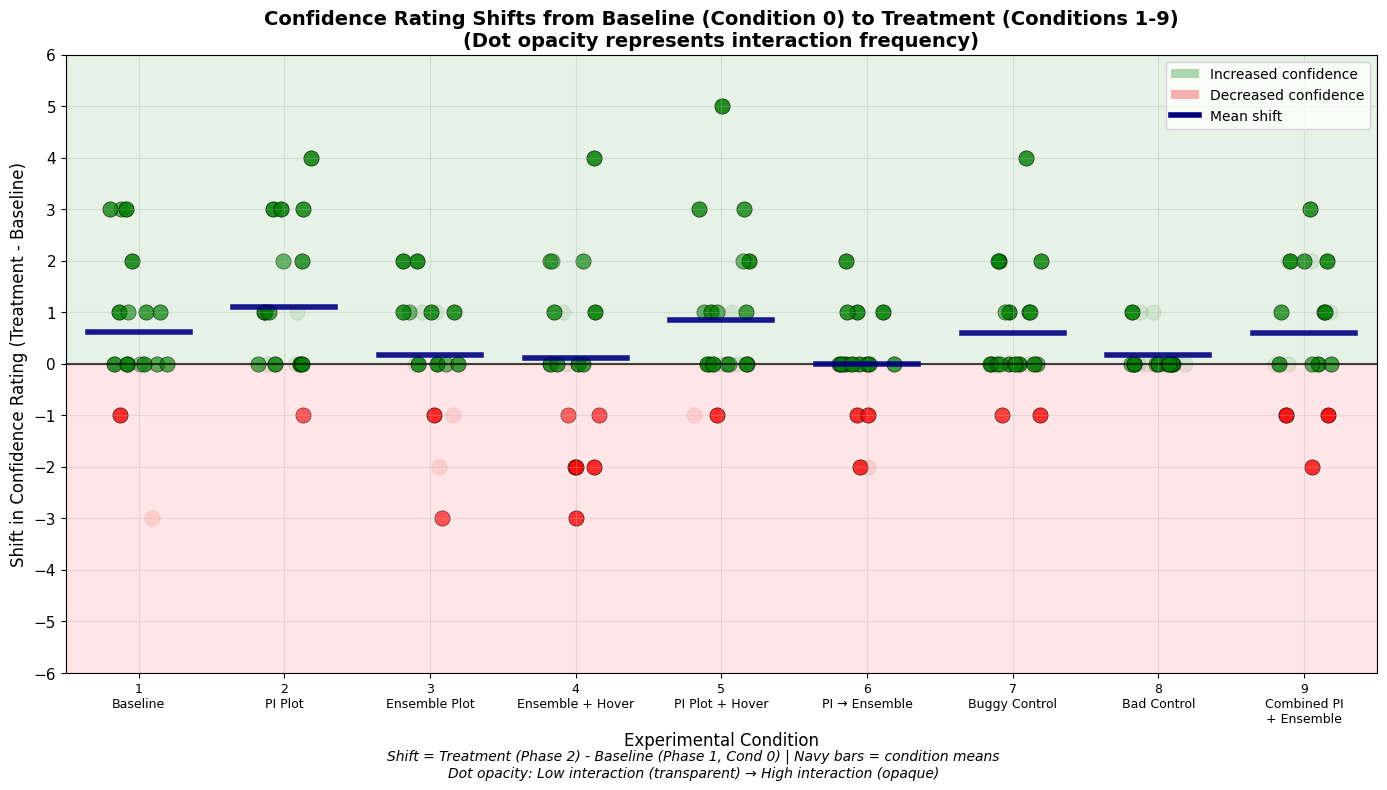

In [65]:
# Modified function to use interaction_freq for opacity instead of fixed alpha
def create_confidence_shift_plot_v2(phase1_data, phase2_data):
	"""
	Create a dot plot showing the shift in confidence_rating from Phase 1 (baseline) to Phase 2.
	
	Parameters:
	- phase1_data: DataFrame with Phase 1 data (condition 0 baseline)
				   Columns: participant_id, confidence_rating
	- phase2_data: DataFrame with Phase 2 data (conditions 1-9)
				   Columns: participant_id, condition_id, confidence_rating, interaction_freq
	
	Shift is calculated as Phase 2 - Phase 1 (baseline).
	Dot opacity represents interaction frequency.
	"""
	
	# Define condition mapping
	condition_names = {
		1: "Baseline", 
		2: "PI Plot",
		3: "Ensemble Plot",
		4: "Ensemble + Hover", 
		5: "PI Plot + Hover",
		6: "PI → Ensemble",
		7: "Buggy Control",
		8: "Bad Control",
		9: "Combined PI\n+ Ensemble"
	}
	
	# Helper function to extract condition number
	def extract_condition_number(condition_id):
		if pd.isna(condition_id) or condition_id == 'unknown':
			return -1
		try:
			parts = str(condition_id).split('_')
			if len(parts) >= 2:
				return int(parts[1])
		except:
			pass
		return -1
	
	# Process Phase 1 data (baseline - condition 0)
	phase1_dict = {}  # participant_id -> confidence_rating
	for _, row in phase1_data.iterrows():
		if pd.notna(row['confidence_rating']):
			pid = row.get('participant_id', row.name)
			phase1_dict[pid] = row['confidence_rating']
	
	# Process Phase 2 data and calculate shifts
	shift_data = []
	for _, row in phase2_data.iterrows():
		if pd.notna(row['confidence_rating']):
			pid = row.get('participant_id', row.name)
			cond_num = extract_condition_number(row['condition_id'])
			
			# Only include conditions 1-9 and participants with baseline data
			if cond_num >= 1 and cond_num <= 9 and pid in phase1_dict:
				baseline_confidence = phase1_dict[pid]
				
				# Calculate shift
				shift = row['confidence_rating'] - baseline_confidence
				
				# Get interaction frequency (default to 0 if missing)
				interaction_freq = row.get('interaction_freq', 0)
				
				shift_data.append({
					'participant_id': pid,
					'condition_number': cond_num,
					'shift': shift,
					'interaction_freq': interaction_freq
				})
	
	if len(shift_data) == 0:
		print("No matched data found for shift calculation")
		print(f"Phase 1 participants: {len(phase1_dict)}")
		print(f"Phase 2 rows: {len(phase2_data)}")
		return None
	
	shift_df = pd.DataFrame(shift_data)
	
	# Normalize interaction_freq to 0.1-1.0 for opacity (for visibility)
	min_freq = shift_df['interaction_freq'].min()
	max_freq = shift_df['interaction_freq'].max()
	if max_freq > min_freq:
		shift_df['opacity'] = 0.1 + (shift_df['interaction_freq'] - min_freq) / (max_freq - min_freq) * 0.9
	else:
		shift_df['opacity'] = 0.7  # Default opacity if all frequencies are the same
	
	# Create the plot
	fig, ax = plt.subplots(1, 1, figsize=(14, 8))
	
	# Add horizontal line at y=0
	ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
	
	# Add shaded regions
	ax.axhspan(0, 6, alpha=0.1, color='green', label='Increased confidence')
	ax.axhspan(-6, 0, alpha=0.1, color='red', label='Decreased confidence')
	
	# Color points based on direction of shift
	colors = ['green' if s >= 0 else 'red' for s in shift_df['shift']]
	
	# Add jitter to x-axis to avoid overlapping points
	np.random.seed(42)  # For reproducibility
	jitter = np.random.uniform(-0.2, 0.2, len(shift_df))
	x_positions = shift_df['condition_number'] + jitter
	
	# Plot the shifts with interaction frequency-based opacity
	for x, y, opacity, color in zip(x_positions, shift_df['shift'], shift_df['opacity'], colors):
		ax.scatter(x, y, alpha=opacity, s=120, c=color, edgecolors='black', linewidth=0.5)
	
	# Calculate and plot mean shift per condition
	mean_shifts = shift_df.groupby('condition_number')['shift'].mean()
	for cond, mean_shift in mean_shifts.items():
		ax.plot([cond - 0.35, cond + 0.35], [mean_shift, mean_shift], 
			   color='navy', linewidth=4, alpha=0.9)
	
	# Set up the plot
	ax.set_title('Confidence Rating Shifts from Baseline (Condition 0) to Treatment (Conditions 1-9)\n(Dot opacity represents interaction frequency)', 
				fontsize=14, fontweight='bold')
	ax.set_xlabel('Experimental Condition', fontsize=12)
	ax.set_ylabel('Shift in Confidence Rating (Treatment - Baseline)', fontsize=12)
	ax.set_ylim(-6, 6)  # Confidence is typically 1-7 scale, so max shift is ±6
	ax.set_xlim(0.5, 9.5)
	ax.set_xticks(range(1, 10))
	ax.set_yticks(range(-6, 7))
	ax.grid(True, alpha=0.3, axis='y')
	
	# Create condition labels for x-axis
	condition_labels = []
	for i in range(1, 10):
		name = condition_names.get(i, f"Cond {i}")
		condition_labels.append(f"{i}\n{name}")
	
	ax.set_xticklabels(condition_labels, fontsize=9, ha='center')
	
	# Add custom legend
	from matplotlib.patches import Patch
	from matplotlib.lines import Line2D
	legend_elements = [
		Patch(facecolor='green', alpha=0.3, label='Increased confidence'),
		Patch(facecolor='red', alpha=0.3, label='Decreased confidence'),
		Line2D([0], [0], color='navy', linewidth=4, label='Mean shift')
	]
	ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
	
	# Add explanation
	fig.text(0.5, 0.02, 'Shift = Treatment (Phase 2) - Baseline (Phase 1, Cond 0) | Navy bars = condition means\nDot opacity: Low interaction (transparent) → High interaction (opaque)', 
			 ha='center', fontsize=10, style='italic')
	
	plt.tight_layout()
	plt.subplots_adjust(bottom=0.15)
	
	# Print summary statistics
	print(f"\nConfidence Rating Shift Summary:")
	print(f"Participants with matched baseline: {len(shift_df)}")
	print(f"Interaction frequency range: {min_freq} - {max_freq}")
	print(f"\nMean shift by condition (from Condition 0 baseline):")
	print("-" * 60)
	for cond in range(1, 10):
		cond_data = shift_df[shift_df['condition_number'] == cond]
		if len(cond_data) > 0:
			mean = cond_data['shift'].mean()
			std = cond_data['shift'].std()
			n = len(cond_data)
			
			direction = "↑" if mean > 0 else "↓" if mean < 0 else "→"
			cond_name = condition_names.get(cond, 'Unknown')
			print(f"  Condition {cond} ({cond_name}): {direction} {mean:+.2f} (SD={std:.2f}, n={n})")
		else:
			print(f"  Condition {cond}: No data")
	
	plt.show()
	
	return shift_df

# Test the new function
shift_summary_v2 = create_confidence_shift_plot_v2(phase1_data, phase2_data)

### Trust and Usability Measures by Condition

In [66]:
# Define question structures for each survey type

interactionQuestions = [
	{
		"prompt": "I was in control of my navigation through this interface.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "navigation_control"
	},
	{
		"prompt": "I had some control over the content of this interface that I wanted to see.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "content_control"
	},
	{
		"prompt": "I was in control over the pace of my visit to this interface.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "pace_control"
	},
	{
		"prompt": "I could communicate with the company directly for further questions about the company or its products if I wanted to.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "company_communication"
	},
	{
		"prompt": "The interface had the ability to respond to my specific questions quickly and efficiently.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "interface_responsiveness"
	},
	{
		"prompt": "I could communicate in real time with other customers who shared my interest in this interface.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "customer_communication"
	},
	{
		"prompt": "I felt I just had a personal conversation with a sociable, knowledgeable and warm representative from the company.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "personal_conversation"
	},
	{
		"prompt": "The interface was like talking back to me while I clicked through the interface.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "interface_interaction"
	},
	{
		"prompt": "I perceived the interface to be sensitive to my needs for product information.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "interface_sensitivity"
	}
]

visualizationTrustQuestions = [
	{
		"prompt": "I was skeptical about the information presented in this visualization.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "skeptical_rating"
	},
	{
		"prompt": "I trusted this data.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "data_trust"
	},
	{
		"prompt": "I found this visualization difficult to use.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "usability_difficulty"
	},
	{
		"prompt": "I found this visualization easy to understand.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "comprehension_ease"
	}
]

personalityQuestions = [
	{
		"prompt": "I respect others.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "respect_others"
	},
	{
		"prompt": "I have a good word for everyone.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "good_word_everyone"
	},
	{
		"prompt": "I retreat from others.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "retreat_from_others"
	},
	{
		"prompt": "I avoid contacts with others.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "avoid_contacts"
	}
]

## 4. Trust and Usability Visualizations

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

def create_sectioned_trust_plots(data, condition_names, questions, section_title="Survey Results"):
	"""
	Create figures with subplots for all questions in the provided question list.
	Each subplot shows ratings by condition for that question.
	
	Args:
		data: DataFrame with survey response data
		condition_names: Dict mapping condition numbers to names
		questions: List of question dictionaries with 'type' and 'prompt' keys
		section_title: Title for the overall figure
	"""
	if not questions:  # Skip if no questions provided
		print(f"No questions provided for {section_title}")
		return
		
	n = len(questions)
	fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(16, 4*n), sharex=True)
	if n == 1:
		axes = [axes]

	for ax, q in zip(axes, questions):
		measure_key = q["type"]
		measure_name = q["prompt"]

		# Filter data for this measure
		measure_data = data[pd.notna(data[measure_key]) & pd.notna(data["condition_id"])]

		values, cond_nums = [], []

		for _, row in measure_data.iterrows():
			try:
				cond_num = int(str(row["condition_id"]).split("_")[1])
			except:
				continue
			if cond_num == 0:
				continue
			values.append(row[measure_key])
			cond_nums.append(cond_num)

		if len(values) > 0:
			ax.scatter(cond_nums, values, alpha=0.7, s=120, edgecolors='black', color="#1f77b4")

			# Plot mean per condition
			df_plot = pd.DataFrame({"cond": cond_nums, "val": values})
			cond_means = df_plot.groupby("cond")["val"].mean()
			for c, mean_val in cond_means.items():
				ax.plot([c-0.3, c+0.3], [mean_val, mean_val], "r-", linewidth=3, alpha=0.8)

		ax.set_title(measure_name, fontsize=12, fontweight="bold", wrap=True)
		ax.set_ylim(-0.5, 6.5)
		ax.set_xlim(0.5, 9.5)
		ax.set_xticks(range(1, 10))

		# X-axis labels
		labels = []
		for j in range(1, 10):
			name = condition_names.get(j, "Unknown")
			if len(name) > 10 and " " in name:
				words = name.split()
				mid = len(words) // 2
				name = " ".join(words[:mid]) + "\n" + " ".join(words[mid:])
			labels.append(f"{j}\n{name}")
		ax.set_xticklabels(labels, fontsize=9)

		ax.set_xlabel("Experimental Condition", fontsize=10)
		ax.set_ylabel("Rating (0–6)", fontsize=10)
		ax.grid(True, alpha=0.3)

	fig.suptitle(section_title, fontsize=16, fontweight="bold", y=0.95)
	plt.tight_layout()
	plt.subplots_adjust(top=0.92)
	plt.show()

In [68]:
# Extract survey responses from JSON response column
import json

def extract_survey_responses(data):
	"""Extract survey responses from the JSON response column and add as individual columns"""
	data_copy = data.copy()
	
	for idx, row in data_copy.iterrows():
		if 'response' in row and pd.notna(row['response']):
			try:
				# Parse the JSON response data
				response_data = json.loads(row['response'])
				
				# Add each response as a new column
				for key, value in response_data.items():
					data_copy.at[idx, key] = value
					
			except Exception as e:
				print(f"Error parsing response for row {idx}: {e}")
	
	return data_copy

print("=== EXTRACTING SURVEY RESPONSE DATA ===")

# Extract responses for each dataset
print("Extracting interaction data responses...")
interaction_data_expanded = extract_survey_responses(interaction_data)

print("Extracting trust data responses...")  
trust_data_expanded = extract_survey_responses(trust_data)

print("Extracting demographics data responses...")
demographics_data_expanded = extract_survey_responses(demographics_data)

# Check what columns are now available
print(f"\n=== AFTER EXTRACTION ===")
print(f"Interaction data shape: {interaction_data_expanded.shape}")
print("Interaction data columns:")
interaction_cols = [col for col in interaction_data_expanded.columns if col in ['navigation_control', 'content_control', 'pace_control', 'company_communication', 'interface_responsiveness', 'customer_communication', 'personal_conversation', 'interface_interaction', 'interface_sensitivity']]
print(interaction_cols)

print(f"\nTrust data shape: {trust_data_expanded.shape}")
print("Trust data columns:")
trust_cols = [col for col in trust_data_expanded.columns if col in ['skeptical_rating', 'data_trust', 'usability_difficulty', 'comprehension_ease']]
print(trust_cols)

print(f"\nDemographics data shape: {demographics_data_expanded.shape}")
print("Demographics data columns:")
demo_cols = [col for col in demographics_data_expanded.columns if col in ['respect_others', 'good_word_everyone', 'retreat_from_others', 'avoid_contacts']]
print(demo_cols)

# Update the global variables to use the expanded data
interaction_data = interaction_data_expanded
trust_data = trust_data_expanded
demographics_data = demographics_data_expanded

=== EXTRACTING SURVEY RESPONSE DATA ===
Extracting interaction data responses...
Extracting trust data responses...
Extracting demographics data responses...

=== AFTER EXTRACTION ===
Interaction data shape: (171, 62)
Interaction data columns:
['navigation_control', 'content_control', 'pace_control', 'company_communication', 'interface_responsiveness', 'customer_communication', 'personal_conversation', 'interface_interaction', 'interface_sensitivity']

Trust data shape: (171, 53)
Trust data columns:
['comprehension_ease', 'data_trust', 'skeptical_rating', 'usability_difficulty']

Demographics data shape: (171, 56)
Demographics data columns:
['respect_others', 'good_word_everyone', 'retreat_from_others', 'avoid_contacts']



Creating visualization for trust/usability data...


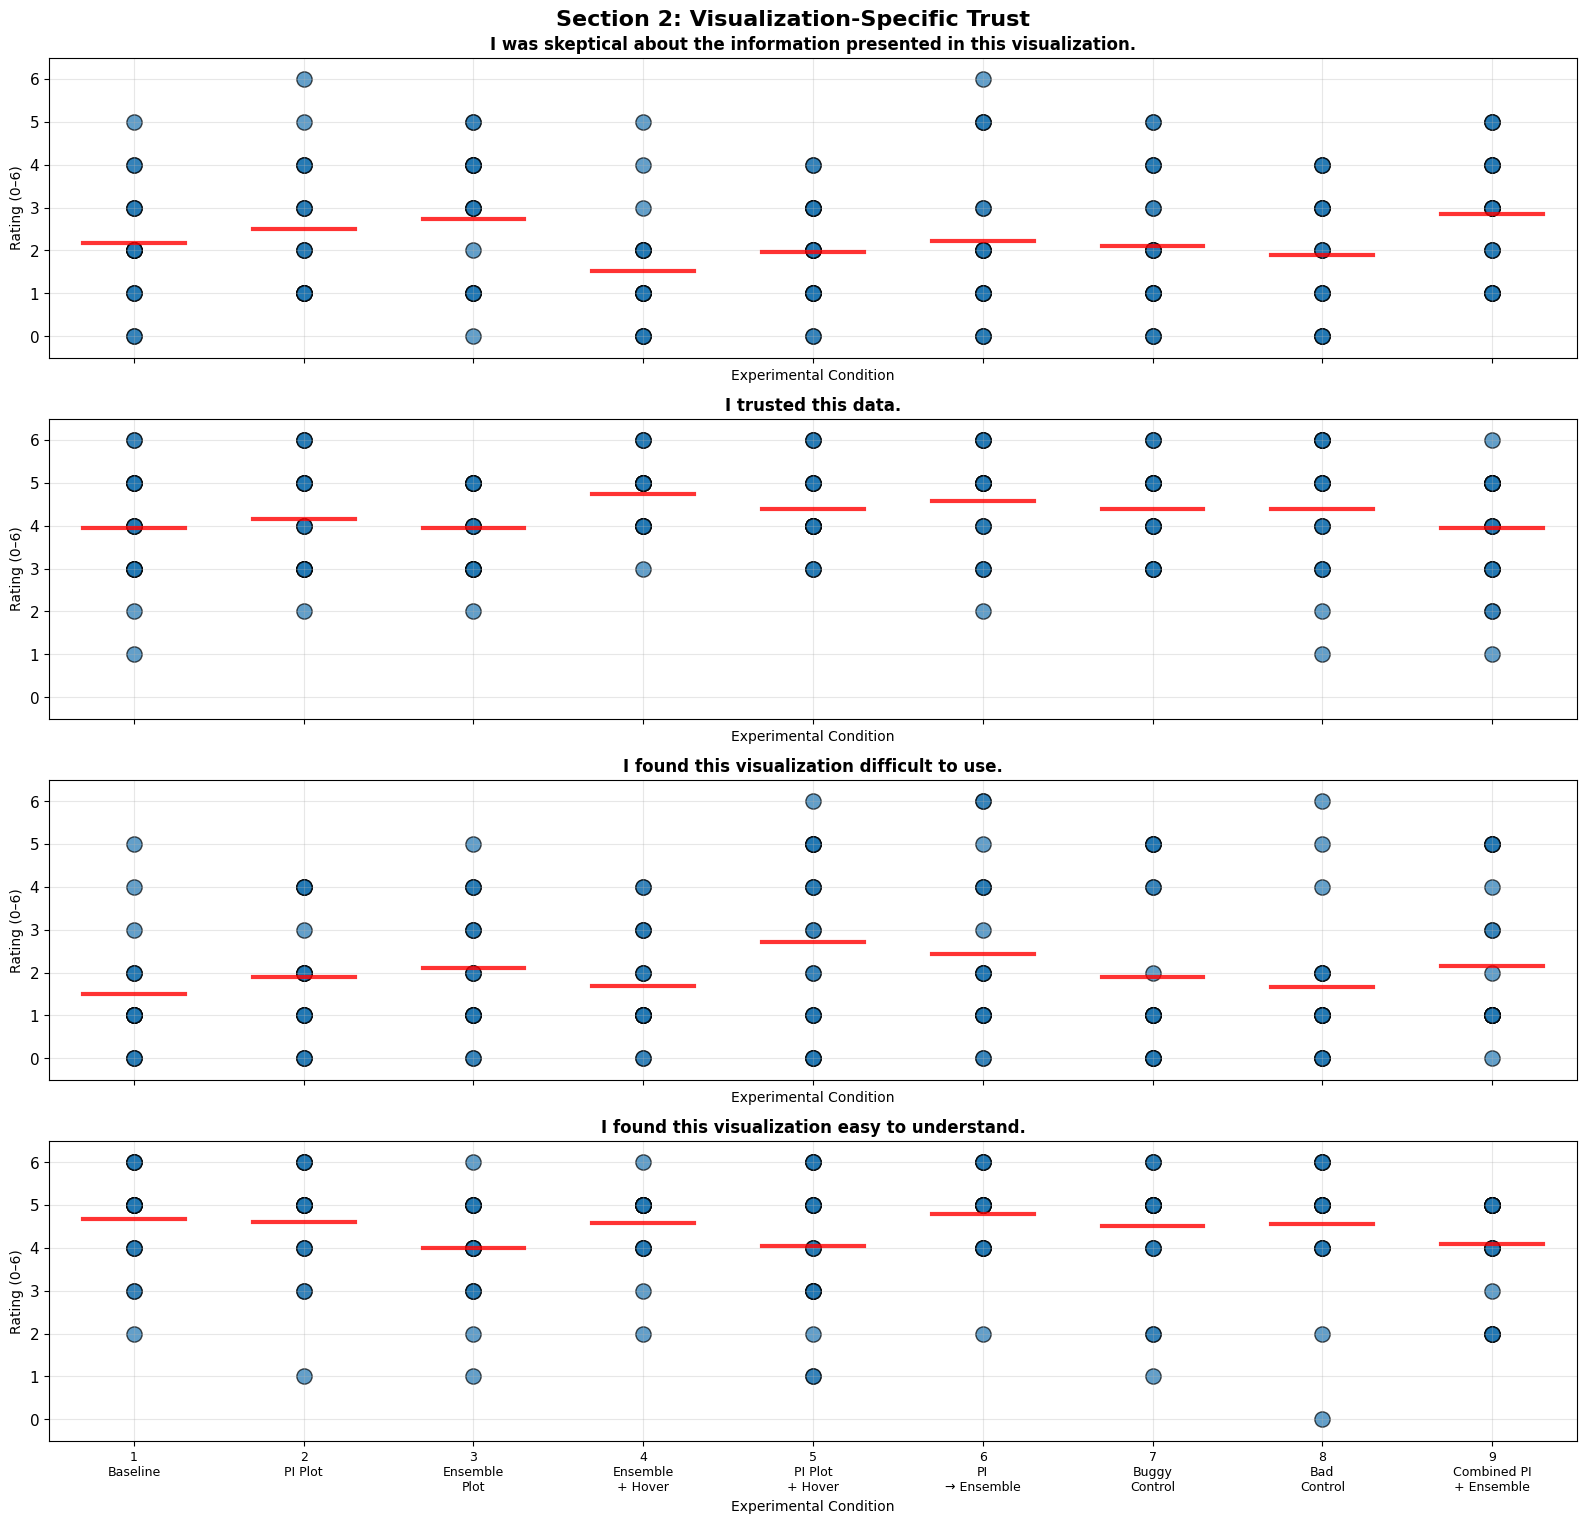

In [69]:
# Generate three separate visualizations for each data type
condition_names = {
	0: "Historical Only",
	1: "Baseline", 
	2: "PI Plot",
	3: "Ensemble Plot",
	4: "Ensemble + Hover", 
	5: "PI Plot + Hover",
	6: "PI → Ensemble",
	7: "Buggy Control",
	8: "Bad Control",
	9: "Combined PI + Ensemble"
}

# # Create visualization for interaction data
# print("Creating visualization for interface interaction data...")
# create_sectioned_trust_plots(
#     data=interaction_data,
#     condition_names=condition_names,
#     questions=interactionQuestions,
#     section_title="Section 1: Interface Interaction & Control"
# )

# Create visualization for trust data  
print("\nCreating visualization for trust/usability data...")
create_sectioned_trust_plots(
	data=trust_data,
	condition_names=condition_names,
	questions=visualizationTrustQuestions,
	section_title="Section 2: Visualization-Specific Trust"
)

In [70]:
def make_heatmap(df, question_cols, title):
	# Keep only the columns we want
	sub = df[['participant_id'] + question_cols].set_index('participant_id')

	# Convert values to numeric
	sub = sub.apply(pd.to_numeric, errors='coerce')

	plt.figure(figsize=(12, 6))
	plt.imshow(sub, aspect='auto', cmap='hot', vmin=-1, vmax=8)

	plt.colorbar(label="Response (1 = light, 7 = dark)")
	plt.title(title)

	# Tick labels
	plt.xticks(
		ticks=np.arange(len(question_cols)),
		labels=question_cols,
		rotation=90
	)
	plt.yticks(
		ticks=np.arange(len(sub.index)),
		labels=sub.index
	)

	plt.tight_layout()
	plt.show()

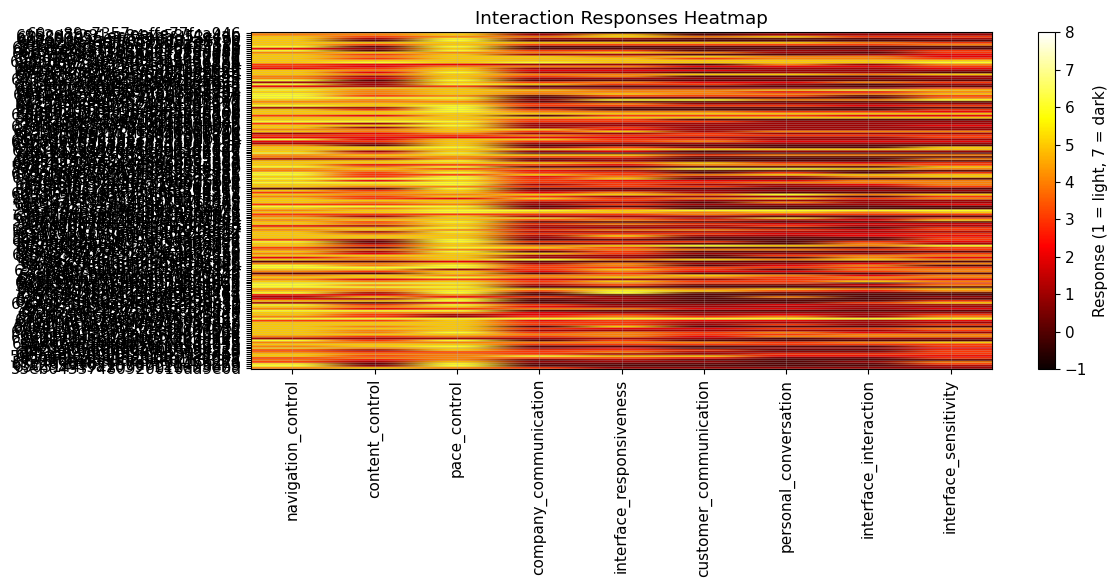

In [71]:
make_heatmap(
	interaction_data,
	interaction_cols,
	"Interaction Responses Heatmap"
)

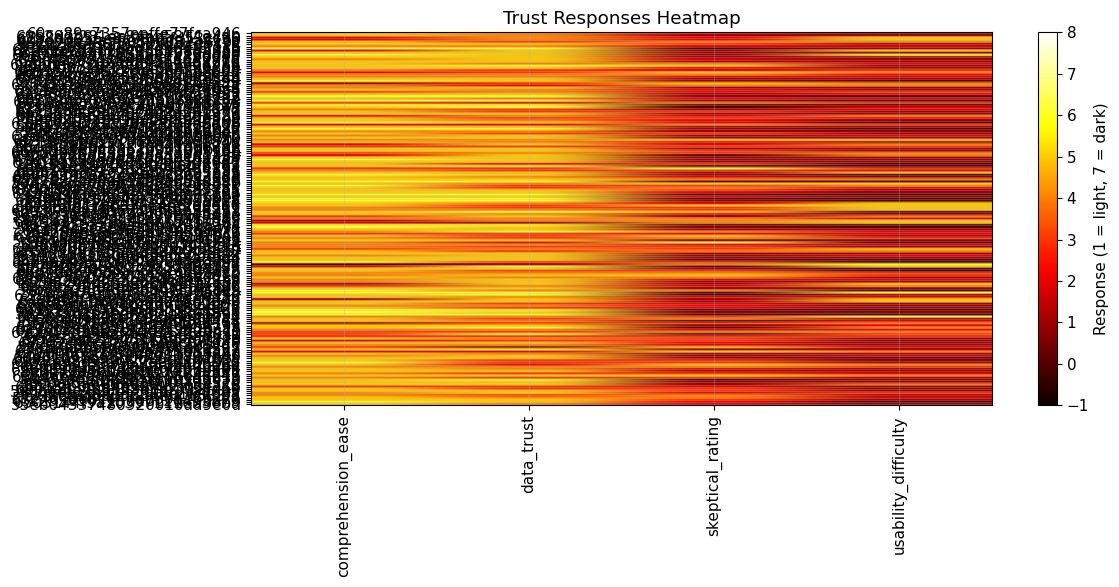

In [72]:
make_heatmap(
	trust_data,
	trust_cols,
	"Trust Responses Heatmap"
)

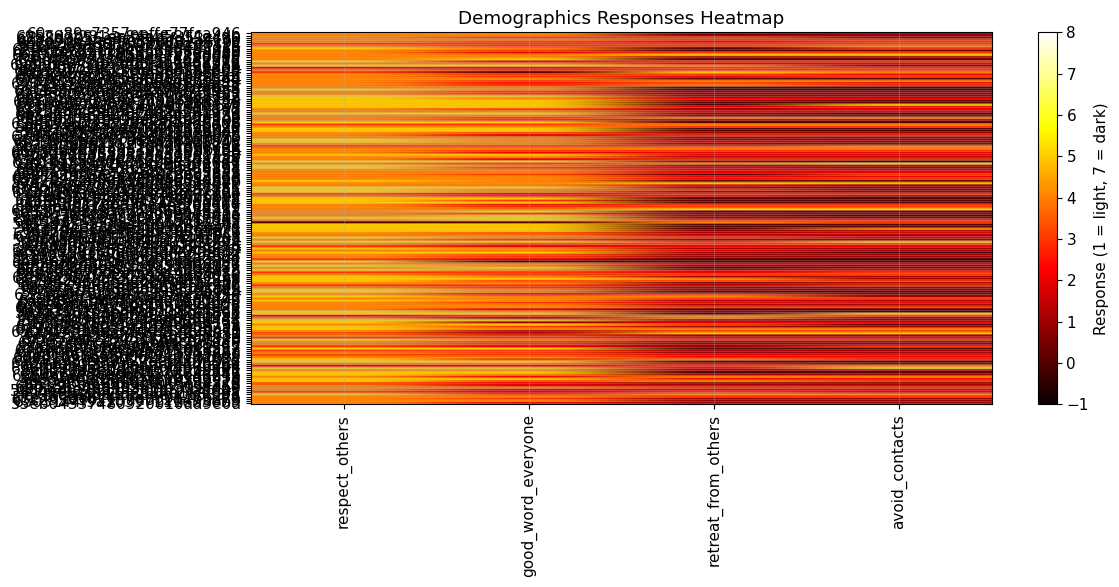

In [73]:
make_heatmap(
	demographics_data,
	demo_cols,
	"Demographics Responses Heatmap"
)

In [74]:
# Calculate averaged interaction scores by condition
import numpy as np
from scipy import stats

# Define interaction question columns
interaction_cols = ['navigation_control', 'content_control', 'pace_control', 
				   'company_communication', 'interface_responsiveness', 
				   'customer_communication', 'personal_conversation', 
				   'interface_interaction', 'interface_sensitivity']

print("=== INTERACTION SCORES BY CONDITION ===")
print("\nCalculating averaged interaction scores (1-7 scale)...")

# Calculate average interaction scores for each participant
interaction_results = []

for _, row in interaction_data.iterrows():
	condition_id = row['condition_id']
	
	# Extract condition number
	try:
		condition_num = int(str(condition_id).split('_')[1])
	except:
		continue
		
	if condition_num == 0:  # Skip condition 0
		continue
	
	# Get all interaction scores for this participant
	scores = []
	for col in interaction_cols:
		if col in row and pd.notna(row[col]):
			scores.append(row[col])
	
	if len(scores) > 0:
		avg_score = np.mean(scores)
		interaction_results.append({
			'condition_id': condition_id,
			'condition_num': condition_num,
			'participant_id': row['participant_id'],
			'avg_interaction_score': avg_score,
			'num_questions': len(scores)
		})

# Convert to DataFrame
results_df = pd.DataFrame(interaction_results)

if len(results_df) > 0:
	# Calculate statistics by condition
	condition_stats = results_df.groupby('condition_num').agg({
		'avg_interaction_score': ['mean', 'std', 'count'],
		'condition_id': 'first'  # Get the condition ID for reference
	}).round(3)
	
	# Flatten column names
	condition_stats.columns = ['mean_score', 'std_score', 'n_participants', 'condition_id']
	
	# Calculate standard error
	condition_stats['se_score'] = (condition_stats['std_score'] / 
								  np.sqrt(condition_stats['n_participants'])).round(3)
	
	# Add condition names
	condition_names = {
		1: "Baseline", 
		2: "PI Plot",
		3: "Ensemble Plot",
		4: "Ensemble + Hover", 
		5: "PI Plot + Hover",
		6: "PI → Ensemble",
		7: "Buggy Control",
		8: "Bad Control",
		9: "Combined PI + Ensemble"
	}
	
	condition_stats['condition_name'] = condition_stats.index.map(condition_names)
	
	# Sort by mean score (high to low)
	condition_stats_ranked = condition_stats.sort_values('mean_score', ascending=False)
	
	print("\n=== INTERACTION SCORES RANKED BY CONDITION (High to Low) ===")
	print("Format: Condition | Mean ± SE | (n participants)")
	print("-" * 65)
	
	for rank, (condition_num, row) in enumerate(condition_stats_ranked.iterrows(), 1):
		condition_name = row['condition_name']
		mean_score = row['mean_score']
		se_score = row['se_score']
		n = int(row['n_participants'])
		
		print(f"{rank:2d}. Condition {condition_num} ({condition_name:18s}) | "
			  f"{mean_score:.2f} ± {se_score:.2f} | (n={n})")
	
	# Display detailed breakdown
	print(f"\n=== DETAILED STATISTICS ===")
	display_cols = ['condition_name', 'mean_score', 'std_score', 'se_score', 'n_participants']
	detailed_stats = condition_stats_ranked[display_cols].copy()
	detailed_stats.index.name = 'Condition'
	print(detailed_stats.to_string())
	
	# Show individual participant scores for verification
	print(f"\n=== INDIVIDUAL PARTICIPANT SCORES ===")
	for condition_num in sorted(condition_stats_ranked.index):
		condition_name = condition_names.get(condition_num, "Unknown")
		participant_scores = results_df[results_df['condition_num'] == condition_num]['avg_interaction_score'].tolist()
		print(f"Condition {condition_num} ({condition_name}): {participant_scores}")
	
else:
	print("No interaction data found for analysis")

=== INTERACTION SCORES BY CONDITION ===

Calculating averaged interaction scores (1-7 scale)...

=== INTERACTION SCORES RANKED BY CONDITION (High to Low) ===
Format: Condition | Mean ± SE | (n participants)
-----------------------------------------------------------------
 1. Condition 9 (Combined PI + Ensemble) | 3.09 ± 0.25 | (n=20)
 2. Condition 6 (PI → Ensemble     ) | 3.08 ± 0.35 | (n=19)
 3. Condition 7 (Buggy Control     ) | 3.02 ± 0.28 | (n=20)
 4. Condition 4 (Ensemble + Hover  ) | 2.95 ± 0.19 | (n=19)
 5. Condition 8 (Bad Control       ) | 2.72 ± 0.23 | (n=18)
 6. Condition 2 (PI Plot           ) | 2.65 ± 0.33 | (n=18)
 7. Condition 3 (Ensemble Plot     ) | 2.60 ± 0.23 | (n=18)
 8. Condition 1 (Baseline          ) | 2.53 ± 0.26 | (n=18)
 9. Condition 5 (PI Plot + Hover   ) | 2.51 ± 0.23 | (n=21)

=== DETAILED STATISTICS ===
                   condition_name  mean_score  std_score  se_score  n_participants
Condition                                                              

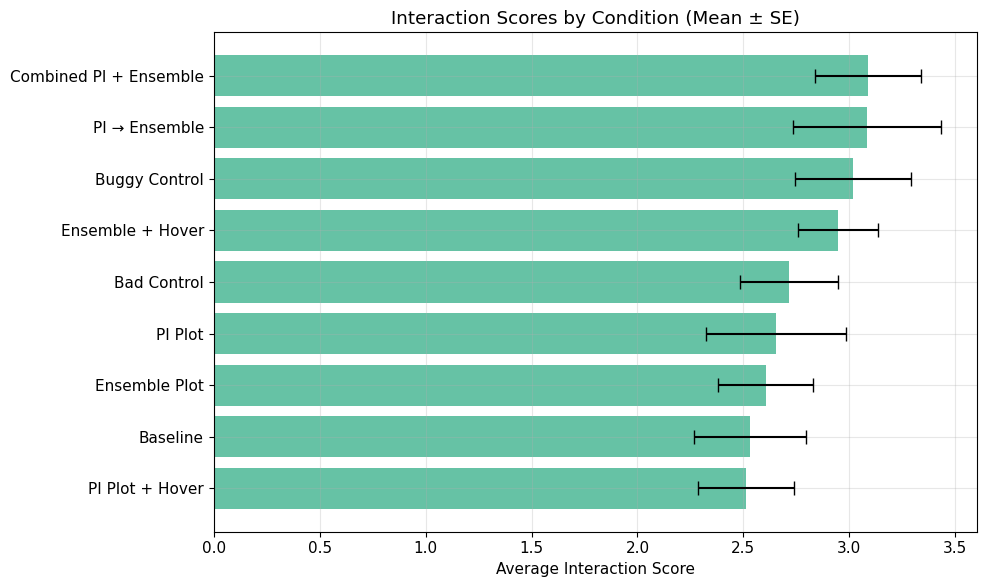

In [75]:

# --- Sort conditions by mean score (high → low) ---
condition_stats_sorted = condition_stats.sort_values("mean_score", ascending=False)

# Extract plotting data
labels = condition_stats_sorted['condition_name'].tolist()
means = condition_stats_sorted['mean_score'].tolist()
errors = condition_stats_sorted['se_score'].tolist()

plt.figure(figsize=(10, 6))

# Horizontal bar chart with error bars
plt.barh(range(len(labels)), means, xerr=errors, capsize=5)
plt.gca().invert_yaxis()  # Highest score at top

plt.yticks(range(len(labels)), labels)
plt.xlabel("Average Interaction Score")
plt.title("Interaction Scores by Condition (Mean ± SE)")

plt.tight_layout()
plt.show()

Composite Trust Score Analysis
Averaging across 4 trust questions:
1. skeptical_rating [REVERSED]
2. data_trust
3. usability_difficulty [REVERSED]
4. trust_composite
Using columns: ['skeptical_rating', 'data_trust', 'usability_difficulty', 'trust_composite']


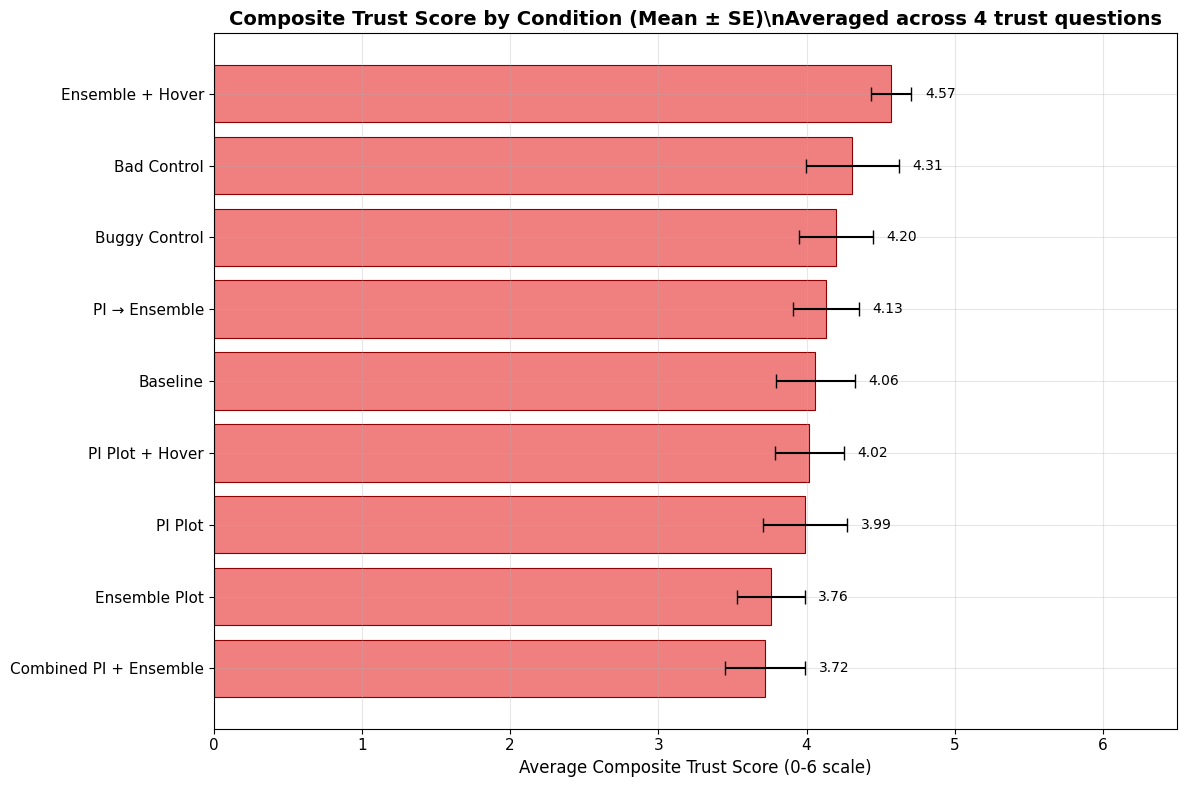

\nComposite Trust Score by Condition:
Ensemble + Hover: 4.57 ± 0.14 (n=19)
Bad Control: 4.31 ± 0.32 (n=18)
Buggy Control: 4.20 ± 0.25 (n=20)
PI → Ensemble: 4.13 ± 0.22 (n=19)
Baseline: 4.06 ± 0.26 (n=18)
PI Plot + Hover: 4.02 ± 0.23 (n=21)
PI Plot: 3.99 ± 0.28 (n=18)
Ensemble Plot: 3.76 ± 0.23 (n=18)
Combined PI + Ensemble: 3.72 ± 0.27 (n=20)


In [76]:
# Create composite trust score averaging across 4 questions with score reversal
def analyze_composite_trust_score(data):
	"""
	Create a composite trust score by averaging across 4 trust questions.
	Questions 1 and 3 (skeptical_rating and usability_difficulty) are reversed.
	
	Parameters:
	- data: DataFrame with trust survey responses
	"""
	
	# Define the 4 trust questions
	trust_columns = ['skeptical_rating', 'data_trust', 'usability_difficulty', 'trust_composite']
	reverse_columns = ['skeptical_rating', 'usability_difficulty']  # Questions 1 and 3 to flip
	
	print("Composite Trust Score Analysis")
	print("=" * 50)
	print("Averaging across 4 trust questions:")
	print("1. skeptical_rating [REVERSED]")
	print("2. data_trust") 
	print("3. usability_difficulty [REVERSED]")
	print("4. trust_composite")
	print("=" * 50)
	
	# Filter for valid conditions
	valid_data = data[
		(data['condition_id'].notna()) & 
		(~data['condition_id'].isin(['unknown', 'condition_0_historical']))
	].copy()
	
	# Check which columns exist
	available_columns = [col for col in trust_columns if col in valid_data.columns]
	missing_columns = [col for col in trust_columns if col not in valid_data.columns]
	
	if missing_columns:
		print(f"Warning: Missing columns: {missing_columns}")
	
	if len(available_columns) == 0:
		print("No trust columns found in data")
		return None
	
	print(f"Using columns: {available_columns}")
	
	# Create reversed scores for specified columns
	for col in available_columns:
		if col in reverse_columns:
			valid_data[f'{col}_rev'] = 6 - valid_data[col]
		else:
			valid_data[f'{col}_rev'] = valid_data[col]
	
	# Calculate composite trust score (average across available questions)
	reversed_columns = [f'{col}_rev' for col in available_columns]
	valid_data['composite_trust_score'] = valid_data[reversed_columns].mean(axis=1, skipna=True)
	
	# Filter for participants with composite scores
	trust_data = valid_data[valid_data['composite_trust_score'].notna()].copy()
	
	if len(trust_data) == 0:
		print("No valid composite trust scores calculated")
		return None
	
	# Calculate statistics by condition
	condition_stats = trust_data.groupby(['condition_id', 'condition_name']).agg({
		'composite_trust_score': ['mean', 'std', 'count']
	}).round(2)
	
	# Flatten column names
	condition_stats.columns = ['mean_score', 'std_score', 'n_score']
	condition_stats = condition_stats.reset_index()
	
	# Calculate standard error
	condition_stats['se_score'] = condition_stats['std_score'] / np.sqrt(condition_stats['n_score'])
	
	# --- Sort conditions by mean score (high → low) ---
	condition_stats_sorted = condition_stats.sort_values("mean_score", ascending=False)
	
	# Extract plotting data
	labels = condition_stats_sorted['condition_name'].tolist()
	means = condition_stats_sorted['mean_score'].tolist()
	errors = condition_stats_sorted['se_score'].tolist()
	
	plt.figure(figsize=(12, 8))
	
	# Horizontal bar chart with error bars
	bars = plt.barh(range(len(labels)), means, xerr=errors, capsize=5, 
					color='lightcoral', edgecolor='darkred', linewidth=0.8)
	plt.gca().invert_yaxis()  # Highest score at top
	
	plt.yticks(range(len(labels)), labels)
	plt.xlabel("Average Composite Trust Score (0-6 scale)", fontsize=12)
	plt.title("Composite Trust Score by Condition (Mean ± SE)\\nAveraged across 4 trust questions", fontsize=14, fontweight='bold')
	
	# Add value labels on bars
	for i, (mean, se) in enumerate(zip(means, errors)):
		plt.text(mean + se + max(means) * 0.02, i, f'{mean:.2f}', 
				va='center', fontsize=10)
	
	# Add grid for better readability
	plt.grid(axis='x', alpha=0.3)
	plt.xlim(0, 6.5)
	
	plt.tight_layout()
	plt.show()
	
	# Print analysis table
	print(f"\\nComposite Trust Score by Condition:")
	print("=" * 60)
	for _, row in condition_stats_sorted.iterrows():
		print(f"{row['condition_name']}: {row['mean_score']:.2f} ± {row['se_score']:.2f} (n={row['n_score']})")
	
	return condition_stats_sorted

# Run the composite trust analysis
composite_trust_results = analyze_composite_trust_score(relevant_trials)

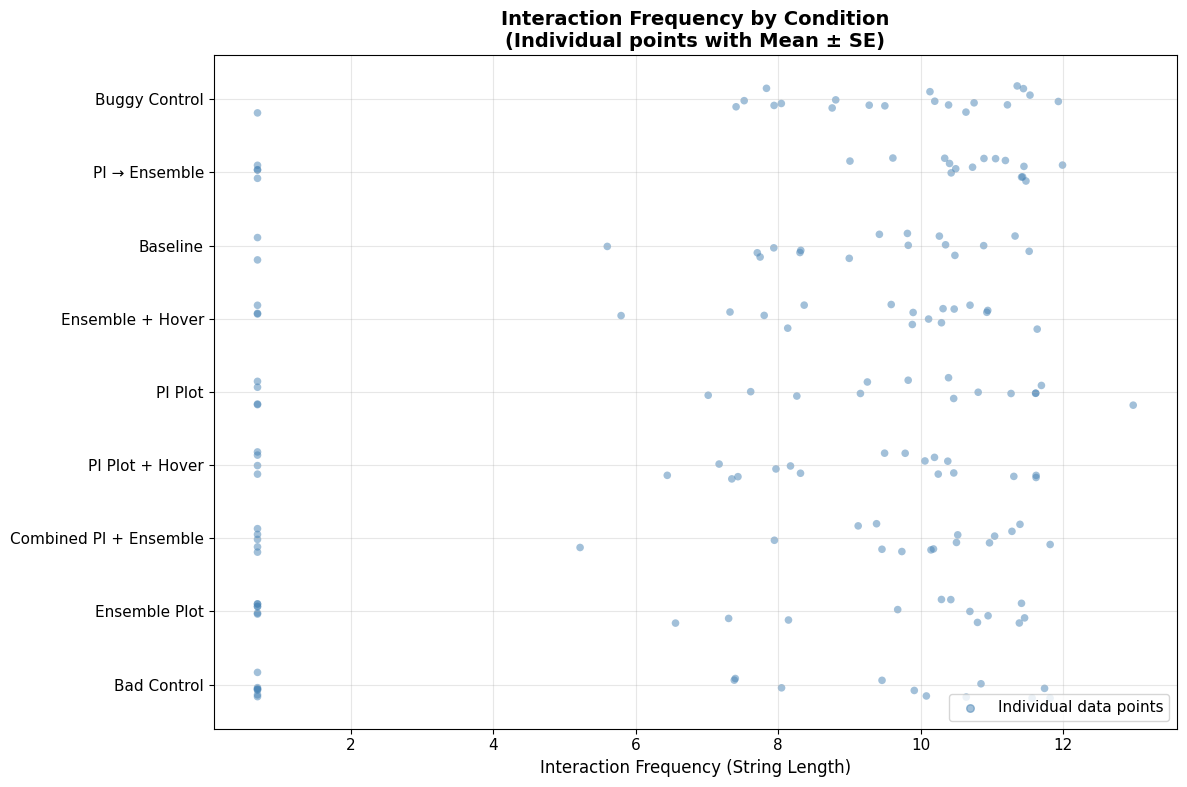


Interaction Frequency by Condition Summary:
Buggy Control: 9.3 ± 0.6 (n=20)
PI → Ensemble: 8.7 ± 1.0 (n=19)
Baseline: 8.3 ± 0.7 (n=18)
Ensemble + Hover: 8.1 ± 0.8 (n=19)
PI Plot: 8.0 ± 1.0 (n=18)
PI Plot + Hover: 7.7 ± 0.8 (n=21)
Combined PI + Ensemble: 7.6 ± 1.0 (n=20)
Ensemble Plot: 6.8 ± 1.1 (n=18)
Bad Control: 6.3 ± 1.1 (n=18)


In [77]:
# Create horizontal dot plot for interaction frequency by condition
def create_interaction_freq_dot_plot(data):
	"""
	Create a horizontal dot plot showing interaction frequency by condition.
	Each dot represents one data point.
	
	Parameters:
	- data: DataFrame with columns: condition_id, condition_name, interaction_freq
	"""
	# import matplotlib.pyplot as plt
	# import pandas as pd
	# import numpy as np
	
	# Filter for valid conditions (exclude unknown and condition_0_historical)
	valid_data = data[
		(data['condition_id'].notna()) & 
		(~data['condition_id'].isin(['unknown', 'condition_0_historical'])) &
		(data['interaction_freq'].notna())
	].copy()

	if len(valid_data) == 0:
		print("No valid interaction frequency data found")
		return None
	
	# Calculate statistics by condition for summary and ordering
	condition_stats = valid_data.groupby(['condition_id', 'condition_name']).agg({
		'interaction_freq': ['mean', 'std', 'count']
	}).round(2)
	
	# Flatten column names
	condition_stats.columns = ['mean_freq', 'std_freq', 'n_freq']
	condition_stats = condition_stats.reset_index()
	
	# Calculate standard error
	condition_stats['se_freq'] = condition_stats['std_freq'] / np.sqrt(condition_stats['n_freq'])
	
	# --- Sort conditions by mean interaction frequency (high → low) ---
	condition_stats_sorted = condition_stats.sort_values("mean_freq", ascending=False)
	
	# Create ordered condition list for y-axis
	ordered_conditions = condition_stats_sorted['condition_name'].tolist()
	
	# Map condition names to y positions
	condition_to_y = {cond: i for i, cond in enumerate(ordered_conditions)}
	
	plt.figure(figsize=(12, 8))
	
	# Plot each data point as a dot with jitter
	for _, row in valid_data.iterrows():
		cond_name = row['condition_name']
		if cond_name in condition_to_y:
			y_pos = condition_to_y[cond_name]
			# Add small random jitter to y position to avoid overplotting
			y_jittered = y_pos + np.random.uniform(-0.2, 0.2)
			plt.scatter(row['interaction_freq'], y_jittered, 
					   alpha=0.5, color='steelblue', s=30, edgecolor='none')
	
	# # Add mean markers with error bars
	# for _, row in condition_stats_sorted.iterrows():
	#     y_pos = condition_to_y[row['condition_name']]
	#     plt.errorbar(row['mean_freq'], y_pos, xerr=row['se_freq'], 
	#                 fmt='D', color='darkred', markersize=8, capsize=5, 
	#                 capthick=2, elinewidth=2, zorder=5)
	
	plt.gca().invert_yaxis()  # Highest frequency at top
	
	plt.yticks(range(len(ordered_conditions)), ordered_conditions)
	plt.xlabel("Interaction Frequency (String Length)", fontsize=12)
	plt.title("Interaction Frequency by Condition\n(Individual points with Mean ± SE)", fontsize=14, fontweight='bold')
	
	# Add grid for better readability
	plt.grid(axis='x', alpha=0.3)
	
	# Add legend
	plt.scatter([], [], alpha=0.5, color='steelblue', s=30, label='Individual data points')
	# plt.errorbar([], [], xerr=[], fmt='D', color='darkred', markersize=8, 
	#             capsize=5, label='Mean ± SE')
	plt.legend(loc='lower right')
	
	plt.tight_layout()
	plt.show()
	
	# Print summary statistics
	print(f"\nInteraction Frequency by Condition Summary:")
	print("=" * 60)
	for _, row in condition_stats_sorted.iterrows():
		print(f"{row['condition_name']}: {row['mean_freq']:.1f} ± {row['se_freq']:.1f} (n={int(row['n_freq'])})")
	
	return condition_stats_sorted

# Create the chart using phase2_data (which should have interaction_freq)
if 'interaction_freq' in phase2_data.columns:
	interaction_freq_stats = create_interaction_freq_dot_plot(phase2_data)
else:
	print("interaction_freq column not found in phase2_data. Make sure the interaction_freq column was created successfully.")

Using columns: ['skeptical_rating', 'data_trust', 'usability_difficulty', 'trust_composite']
               participant_id  interaction_freq
0    54e32a60fdf99b3eae9de85b          7.284821
1    55eb04337480920010aa9e0d         17.438600
2    5694e7b5e0c800000b5a3841         17.283028
3    56a7b5eac89737000b225d0e         17.062575
4    56cc78e3ccc0e20006b82a7d         13.610076
..                        ...               ...
166  696a97da7648c7e49fa8eb36          7.284821
167  6978b98d9a0927ae51d797fd         18.409205
168  6978d78491ea9e2fdea1c5f0         18.207634
169  697aabe738553e0c2718fdb9         17.946541
170  697e28c48ef80590132e5c9c         17.916775

[171 rows x 2 columns]
2 171


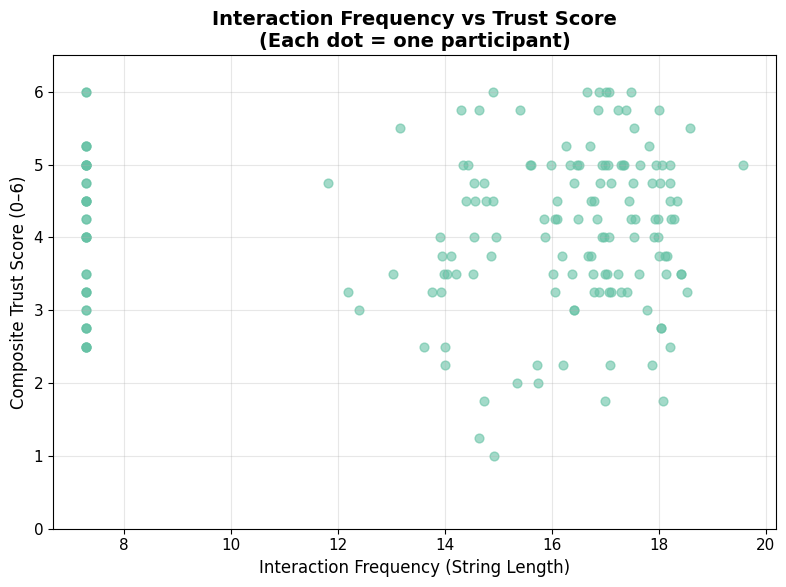

In [78]:
# Scatter plot: Interaction Frequency vs Composite Trust Score (participant-level)
def plot_interaction_vs_trust(data):
	"""
	Scatter plot of interaction frequency vs composite trust score.
	Each dot represents one participant.
	
	Parameters:
	- data: DataFrame containing interaction_freq and trust question responses
	"""
	
 
	# Define the 4 trust questions
	trust_columns = ['skeptical_rating', 'data_trust', 'usability_difficulty', 'trust_composite']
	reverse_columns = ['skeptical_rating', 'usability_difficulty']  # Questions 1 and 3 to flip

	
	# Filter for valid conditions
	valid_data = data[
		(data['condition_id'].notna()) & 
		(~data['condition_id'].isin(['unknown', 'condition_0_historical']))
	].copy()
	
	# Check which columns exist
	available_columns = [col for col in trust_columns if col in valid_data.columns]
	missing_columns = [col for col in trust_columns if col not in valid_data.columns]
	
	if missing_columns:
		print(f"Warning: Missing columns: {missing_columns}")
	
	if len(available_columns) == 0:
		print("No trust columns found in data")
		return None
	
	print(f"Using columns: {available_columns}")
	
	# Create reversed scores for specified columns
	for col in available_columns:
		if col in reverse_columns:
			valid_data[f'{col}_rev'] = 6 - valid_data[col]
		else:
			valid_data[f'{col}_rev'] = valid_data[col]
	
	# Calculate composite trust score (average across available questions)
	reversed_columns = [f'{col}_rev' for col in available_columns]
	valid_data['composite_trust_score'] = valid_data[reversed_columns].mean(axis=1, skipna=True)
	
	# Filter for participants with composite scores
	trust_data = valid_data[valid_data['composite_trust_score'].notna()].copy()
	
	# # Filter valid conditions
	interaction_data = data[
		(data['condition_id'].notna()) & 
		(~data['condition_id'].isin(['unknown', 'condition_0_historical']))
	].copy()
	interact=interaction_data.groupby('participant_id', as_index=False)['interaction_freq'].sum()
	# print(trust_data['composite_trust_score'])
	plt.figure(figsize=(8, 6))
	print(interact)
	print(len(list(interact)),len(list(trust_data['composite_trust_score'])))
	plt.scatter(
		interact['interaction_freq'],
		trust_data['composite_trust_score'],
		alpha=0.6,
		s=40
	)
	
	plt.xlabel("Interaction Frequency (String Length)", fontsize=12)
	plt.ylabel("Composite Trust Score (0–6)", fontsize=12)
	plt.title("Interaction Frequency vs Trust Score\n(Each dot = one participant)",
			  fontsize=14, fontweight='bold')
	
	plt.grid(alpha=0.3)
	plt.ylim(0, 6.5)
	
	plt.tight_layout()
	plt.show()
	

# Run the scatter plot
plot_interaction_vs_trust(relevant_trials)

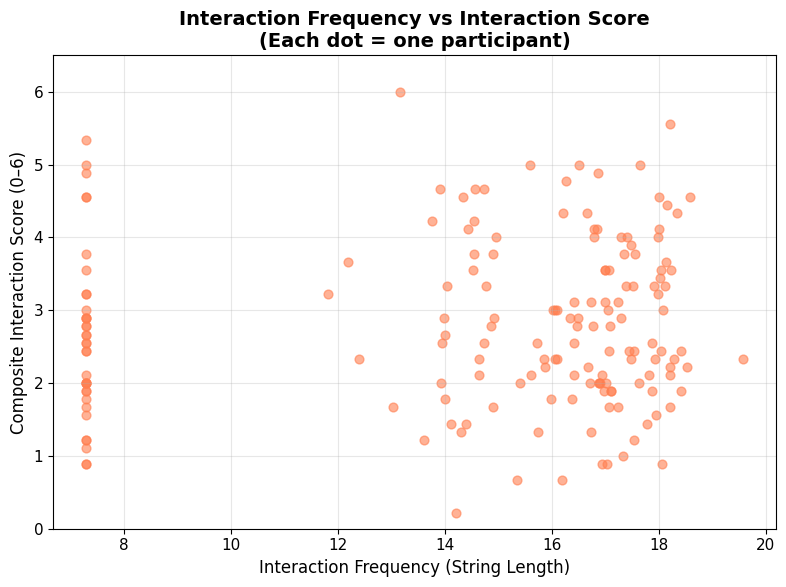

In [82]:
def plot_interaction_vs_interaction_score(data,idata):
		

	# Define interaction question columns
	interaction_cols = ['navigation_control', 'content_control', 'pace_control', 
					'company_communication', 'interface_responsiveness', 
					'customer_communication', 'personal_conversation', 
					'interface_interaction', 'interface_sensitivity']

	
	# Filter for valid conditions
	valid_data = data[
		(data['condition_id'].notna()) & 
		(~data['condition_id'].isin(['unknown', 'condition_0_historical']))
	].copy()
	
	valid_data['composite_interaction_score'] = valid_data[interaction_cols].mean(axis=1, skipna=True)
	
	# Filter for participants with composite scores
	# interaction_data = valid_data['usability_difficulty']
	# print(len(valid_data['composite_interaction_score']))
	# # Filter valid conditions
	interaction_data = idata[
		(idata['condition_id'].notna()) & 
		(~idata['condition_id'].isin(['unknown', 'condition_0_historical']))
	].copy()
	interact=interaction_data.groupby('participant_id', as_index=False)['interaction_freq'].sum()

	plt.figure(figsize=(8, 6))


	plt.scatter(
		interact['interaction_freq'],
		valid_data['composite_interaction_score'],
		alpha=0.6,
		s=40,
		color='coral'
	)
	
	plt.xlabel("Interaction Frequency (String Length)", fontsize=12)
	plt.ylabel("Composite Interaction Score (0–6)", fontsize=12)
	plt.title("Interaction Frequency vs Interaction Score\n(Each dot = one participant)",
			  fontsize=14, fontweight='bold')
	
	plt.grid(alpha=0.3)
	plt.ylim(0, 6.5)
	
	plt.tight_layout()
	plt.show()
	

# Run the scatter plot
# print(relevant_trials.usability_composite)
# print(relevant_trials.usability_difficulty)
# print(interaction_data.columns)
plot_interaction_vs_interaction_score(interaction_data,relevant_trials)

8       5.0
9       3.0
28      1.0
29      5.0
48      6.0
       ... 
3395    5.0
3414    6.0
3415    6.0
3434    3.0
3435    3.0
Name: confidence_rating, Length: 342, dtype: float64


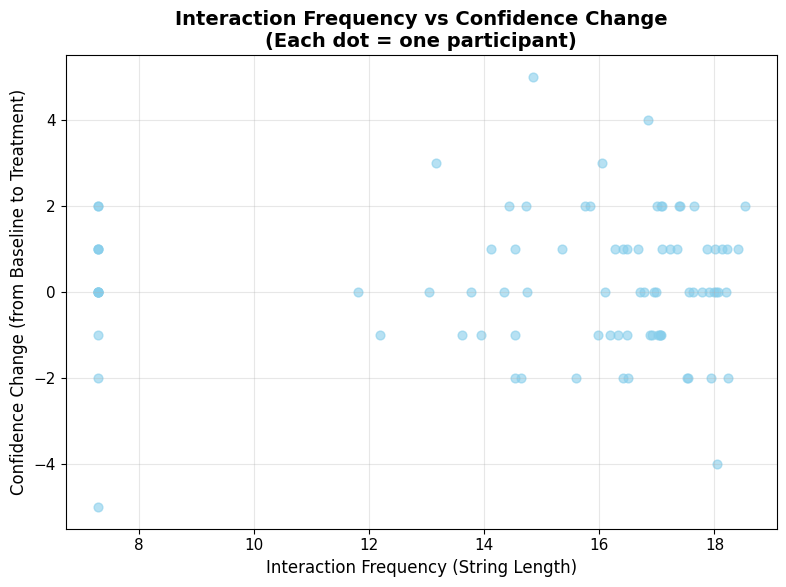

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_interaction_vs_confidence_delta(idata):
    interaction_data = idata[
        (idata['condition_id'].notna()) & 
        (~idata['condition_id'].isin(['unknown', 'condition_0_historical']))
    ].copy()

    # Sum interaction frequency per participant
    interact = interaction_data.groupby('participant_id', as_index=False)['interaction_freq'].sum()

    # Keep rows with confidence ratings and sort by index to preserve order
    conf = interaction_data[['participant_id', 'confidence_rating']].dropna().sort_index().reset_index(drop=True)

    # Compute delta = odd - even (pairwise)
    even_conf = conf.iloc[::2].reset_index(drop=True)
    odd_conf = conf.iloc[1::2].reset_index(drop=True)

    delta = odd_conf.copy()
    delta['confidence_delta'] = odd_conf['confidence_rating'] - even_conf['confidence_rating']

    # Merge with interaction frequency
    merged = interact.merge(delta[['participant_id', 'confidence_delta']], on='participant_id', how='inner')

    plt.figure(figsize=(8, 6))

    plt.scatter(
        merged['interaction_freq'],
        merged['confidence_delta'],
        alpha=0.6,
        s=40,
        color='skyblue'
    )

    plt.xlabel("Interaction Frequency (String Length)", fontsize=12)
    plt.ylabel("Confidence Change (from Baseline to Treatment)", fontsize=12)
    plt.title("Interaction Frequency vs Confidence Change\n(Each dot = one participant)", fontsize=14, fontweight='bold')

    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


print(relevant_trials.confidence_rating.dropna())
plot_interaction_vs_confidence_delta(relevant_trials)

![alt text](SCR-20251208-ovoi-1.png)